In [1]:
using Pandas
using DataFrames
using CSV
using PyCall
using PyPlot
using LsqFit
using Printf
using KernelDensity
using Distributions

include("tacos.jl") # Tools to Analyse COmponents Systems

scipy_integrate = pyimport("scipy.integrate")
scipy_stats = pyimport("scipy.stats")
pushfirst!(PyVector(pyimport("sys")."path"), "")
frontiers = pyimport("frontiers_colors");

In [2]:
wm = pyimport("watermark").WaterMark()
wm.watermark("-v -m  -u -n -p scipy -a Filippo_Valle -g -r -b -w")
print(wm._get_datetime())
print(wm._get_sysinfo())

2021-01-28T16:59:25.285145+01:00Dict{Any,Any}("Compiler" => "GCC 9.3.0","Release" => "5.8.0-41-generic","OS" => "Linux","Architecture" => "64bit","CPU cores" => 12,"Machine" => "x86_64","Processor" => "x86_64")

# Global Zipf 

In [3]:
f_gtex = CSV.read("A_gtex.dat", DataFrames.DataFrame).abundance
f_gtex = sort(f_gtex./sum(f_gtex), rev=true);

In [4]:
f_mca = Tacos.load_pickle("mca/data_all.pkl")["freq"]
f_mca = sort(f_mca./sum(f_mca), rev=true);

In [5]:
f_tm = Tacos.load_pickle("tm/data_all.pkl")["freq"]
f_tm = sort(f_tm./sum(f_tm), rev=true);

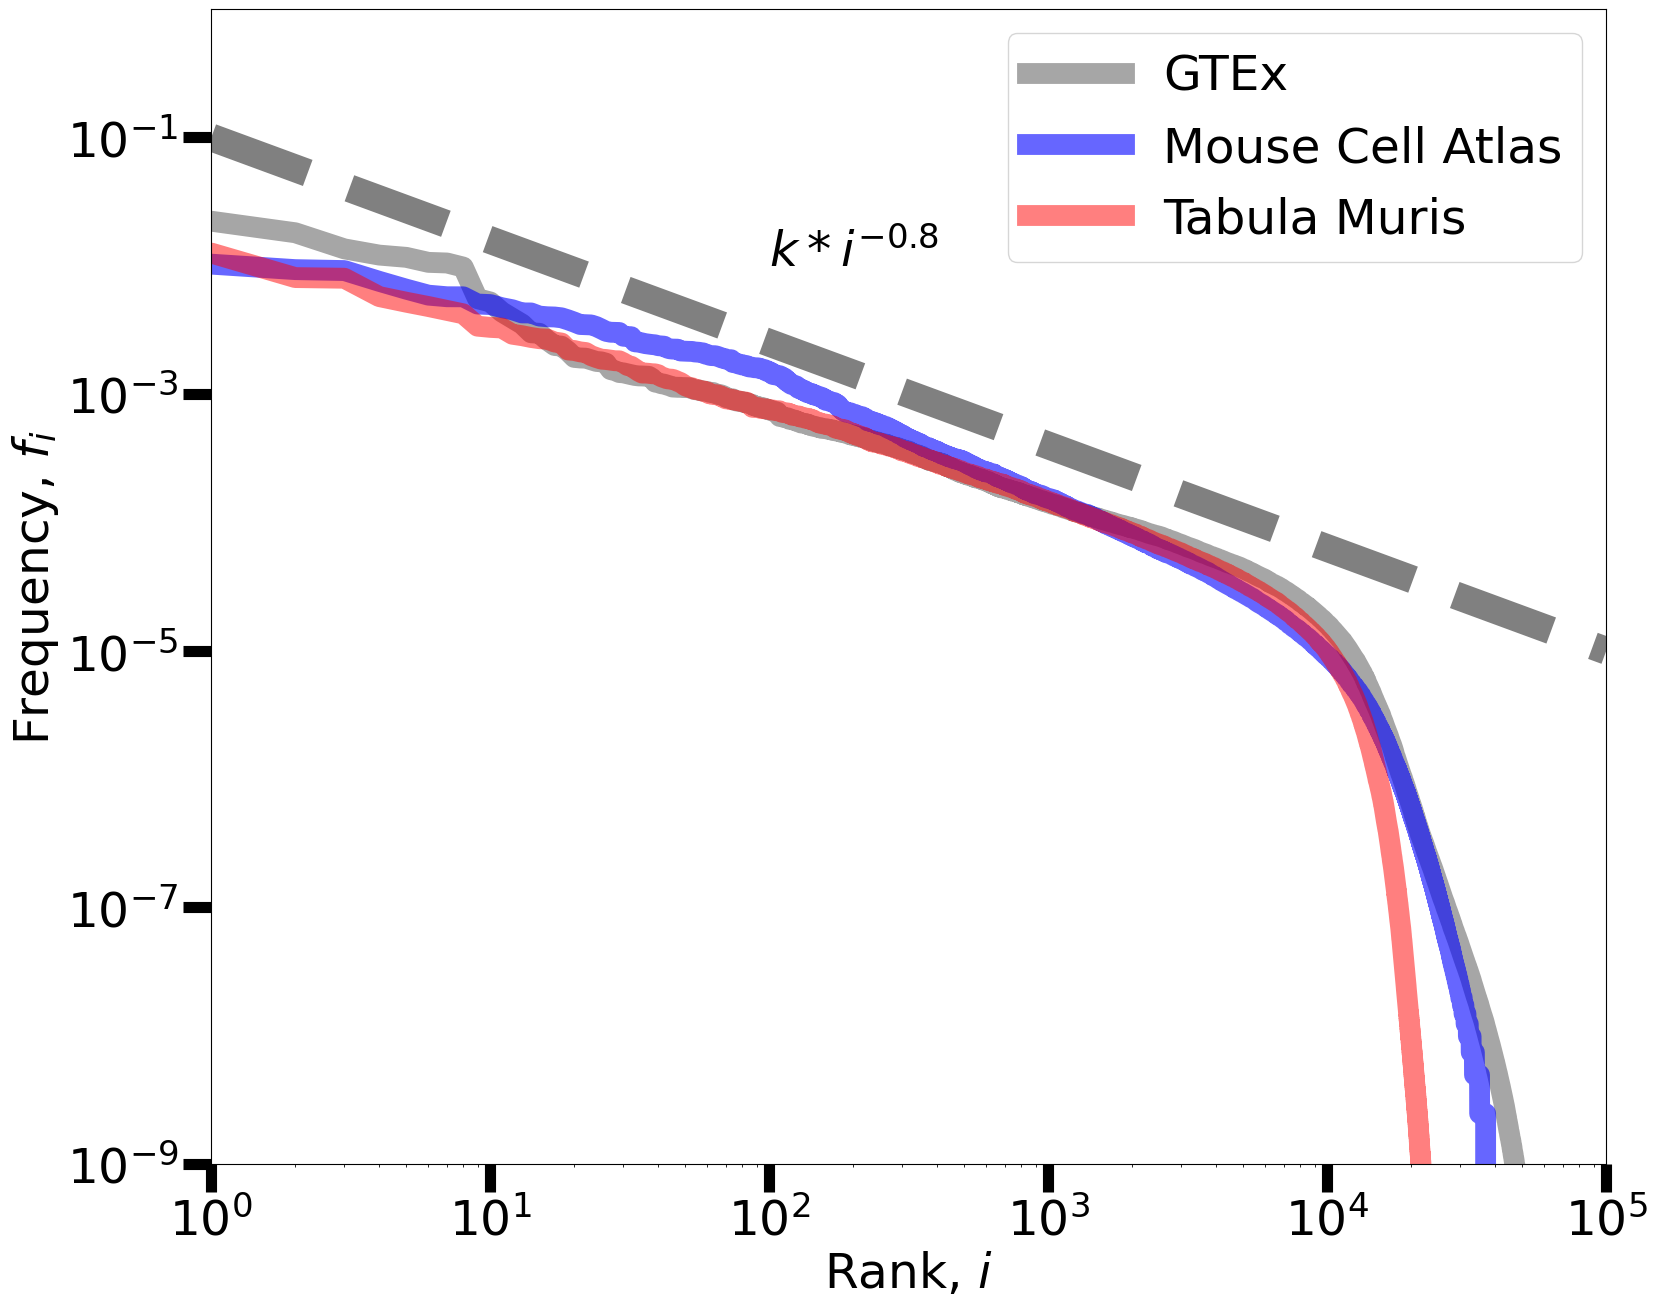

In [6]:
fig, ax = PyPlot.subplots(figsize=(18,15))

X = collect(1:1e5)

ax.plot(X,[1e-1*x^-0.8 for x in X], lw=20, ls="--", color="gray")

ax.plot(f_gtex, label="GTEx", lw=15, color="gray", alpha=0.7)
ax.plot(f_mca, label="Mouse Cell Atlas", lw=15, color="blue", alpha=0.6)
ax.plot(f_tm, label="Tabula Muris", lw=15, color="red", alpha=0.5)


ax.annotate(L"$k*i^{-0.8}$", (1e2,1e-2), fontsize=35)


ax.legend(fontsize=35)
ax.set_yscale("log")
ax.set_xscale("log")

ax.tick_params(labelsize=35, width=8, length=20)
ax.set_xlabel(L"Rank, $i$", fontsize=35)
ax.set_ylabel(L"Frequency, $f_i$", fontsize=35)

ax.set_xlim(1,1e5)
ax.set_ylim(1e-9,1e0)
show()

fig.savefig("zipf_alldatasets.pdf")

## Fit ranges and regimes

In [7]:
# fit the power law
fit_func = function(X, p)
    return p[1]*[x^(-p[2]) for x in X]
end

fit_func_exp = function(X, p)
    return p[1]*[exp(-p[2]*x) for x in X]
end

#7 (generic function with 1 method)

As we describe in the paper, here we search the bounds of the power-law like regime.

Note that in Tabula Muris, we're looking for a local maximum, so *bounds["sx"]["max"]* should be *82* instead of *122*

In [8]:
bounds = Dict()

bounds["dx"] = Dict()
bounds["sx"] = Dict()

bounds["sx"]["min"]=2
bounds["sx"]["max"]=122
bounds["sx"]["step"]=10

bounds["dx"]["min"]=5e2
bounds["dx"]["max"]=2e4
bounds["dx"]["step"]=100

optimize_fit = function(f)
    maxmimum_r2 = -Inf
    optimal_fit = nothing
    optimal_limits = nothing
    fit_exp = nothing
    
    Rs = zeros(Float64, Int64((bounds["sx"]["max"]- bounds["sx"]["min"])/ bounds["sx"]["step"]+1), Int64(( bounds["dx"]["max"]- bounds["dx"]["min"])/ bounds["dx"]["step"]+1))
    for left_side::Int32=range(bounds["sx"]["min"],bounds["sx"]["max"],step=bounds["sx"]["step"]), right_side::Int32=range(bounds["dx"]["min"],bounds["dx"]["max"],step=bounds["dx"]["step"])
        #println(left_side," ", right_side)
        
        x_data = left_side:right_side
        y_data = f[left_side:right_side]
        fit = curve_fit(fit_func, x_data, y_data, [1e-1, 0.8])
        popt, pcov = (coef(fit), estimate_covar(fit))
        r_squared = Tacos.estimate_r2(fit_func, popt, x_data, y_data)
        Rs[Int64((left_side-bounds["sx"]["min"])/bounds["sx"]["step"]+1),Int64((right_side-bounds["dx"]["min"])/bounds["dx"]["step"]+1)]=r_squared
        if r_squared > maxmimum_r2
            maxmimum_r2 = r_squared
            optimal_fit = fit
            optimal_limits = (left_side, right_side)
        end    
    end
    return maxmimum_r2, optimal_fit, optimal_limits, Rs, bounds
end

#11 (generic function with 1 method)

Search the **bounds** of the regimes

In the next cell you can chose from *f_gtex* (the one presented in the paper), *f_mca* or *f_tm*

In [9]:
r2, fit,  limits, Rs, windows = optimize_fit(f_gtex);
CSV.write("rs_gtex.csv",DataFrames.DataFrame(Rs), writeheader=false);

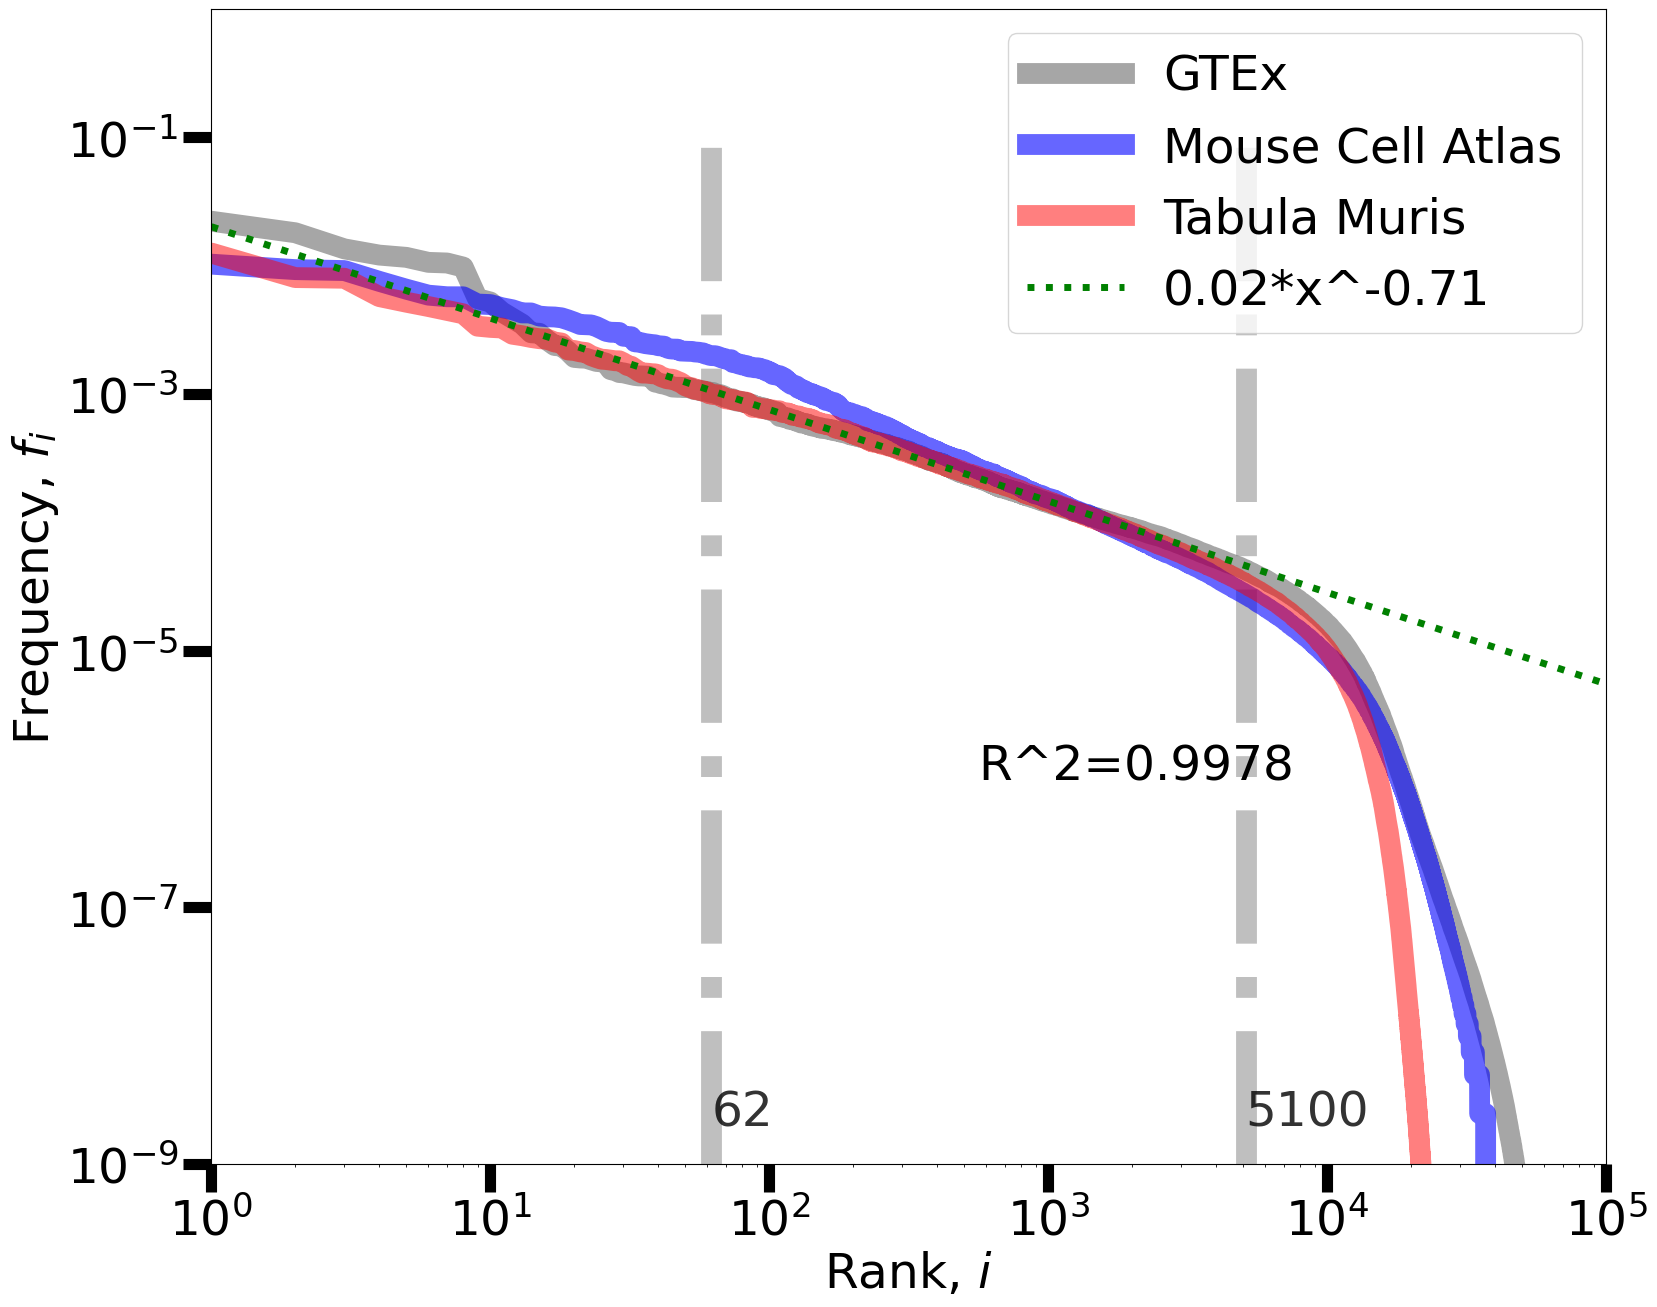

In [10]:
fig, ax = PyPlot.subplots(figsize=(18,15))

popt = coef(fit)

ax.plot(f_gtex, label="GTEx", lw=15, color="gray", alpha=0.7)
ax.plot(f_mca, label="Mouse Cell Atlas", lw=15, color="blue", alpha=0.6)
ax.plot(f_tm, label="Tabula Muris", lw=15, color="red", alpha=0.5)

X = collect(1:1e5)

#ax.plot(X,[1e-1*x^-0.8 for x in X], ls="--", color="gray")
ax.plot(X,[popt[1]*x^-popt[2] for x in X], ls=":", lw=5, color="green", label="$(@sprintf("%.2f", popt[1]))*x^-$(@sprintf("%.2f", popt[2]))")

#ax.annotate(L"$k*i^{-0.8}$", (1e2,1e-2), fontsize=22)
ax.annotate("R^2=$(@sprintf("%.4f", r2))", (10^((log10(limits[1])+log10(limits[2]))/2),1e-6), fontsize=35)

ax.vlines([limits[1] limits[2]], 1e-9, 1e-1, colors="gray", ls="-.", lw=15, alpha =0.5)
ax.annotate("$(limits[1])", (limits[1],2e-9), fontsize=35, alpha=0.8)
ax.annotate("$(limits[2])", (limits[2],2e-9), fontsize=35, alpha=0.8)


ax.legend(fontsize=35)
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel(L"Rank, $i$", fontsize=35)
ax.set_ylabel(L"Frequency, $f_i$", fontsize=35)

ax.tick_params(labelsize=35, width=8, length=20)


ax.set_xlim(1,1e5)
ax.set_ylim(1e-9,1e0)
show()

fig.savefig("zipf_alldatasets_fit_gtex.pdf")

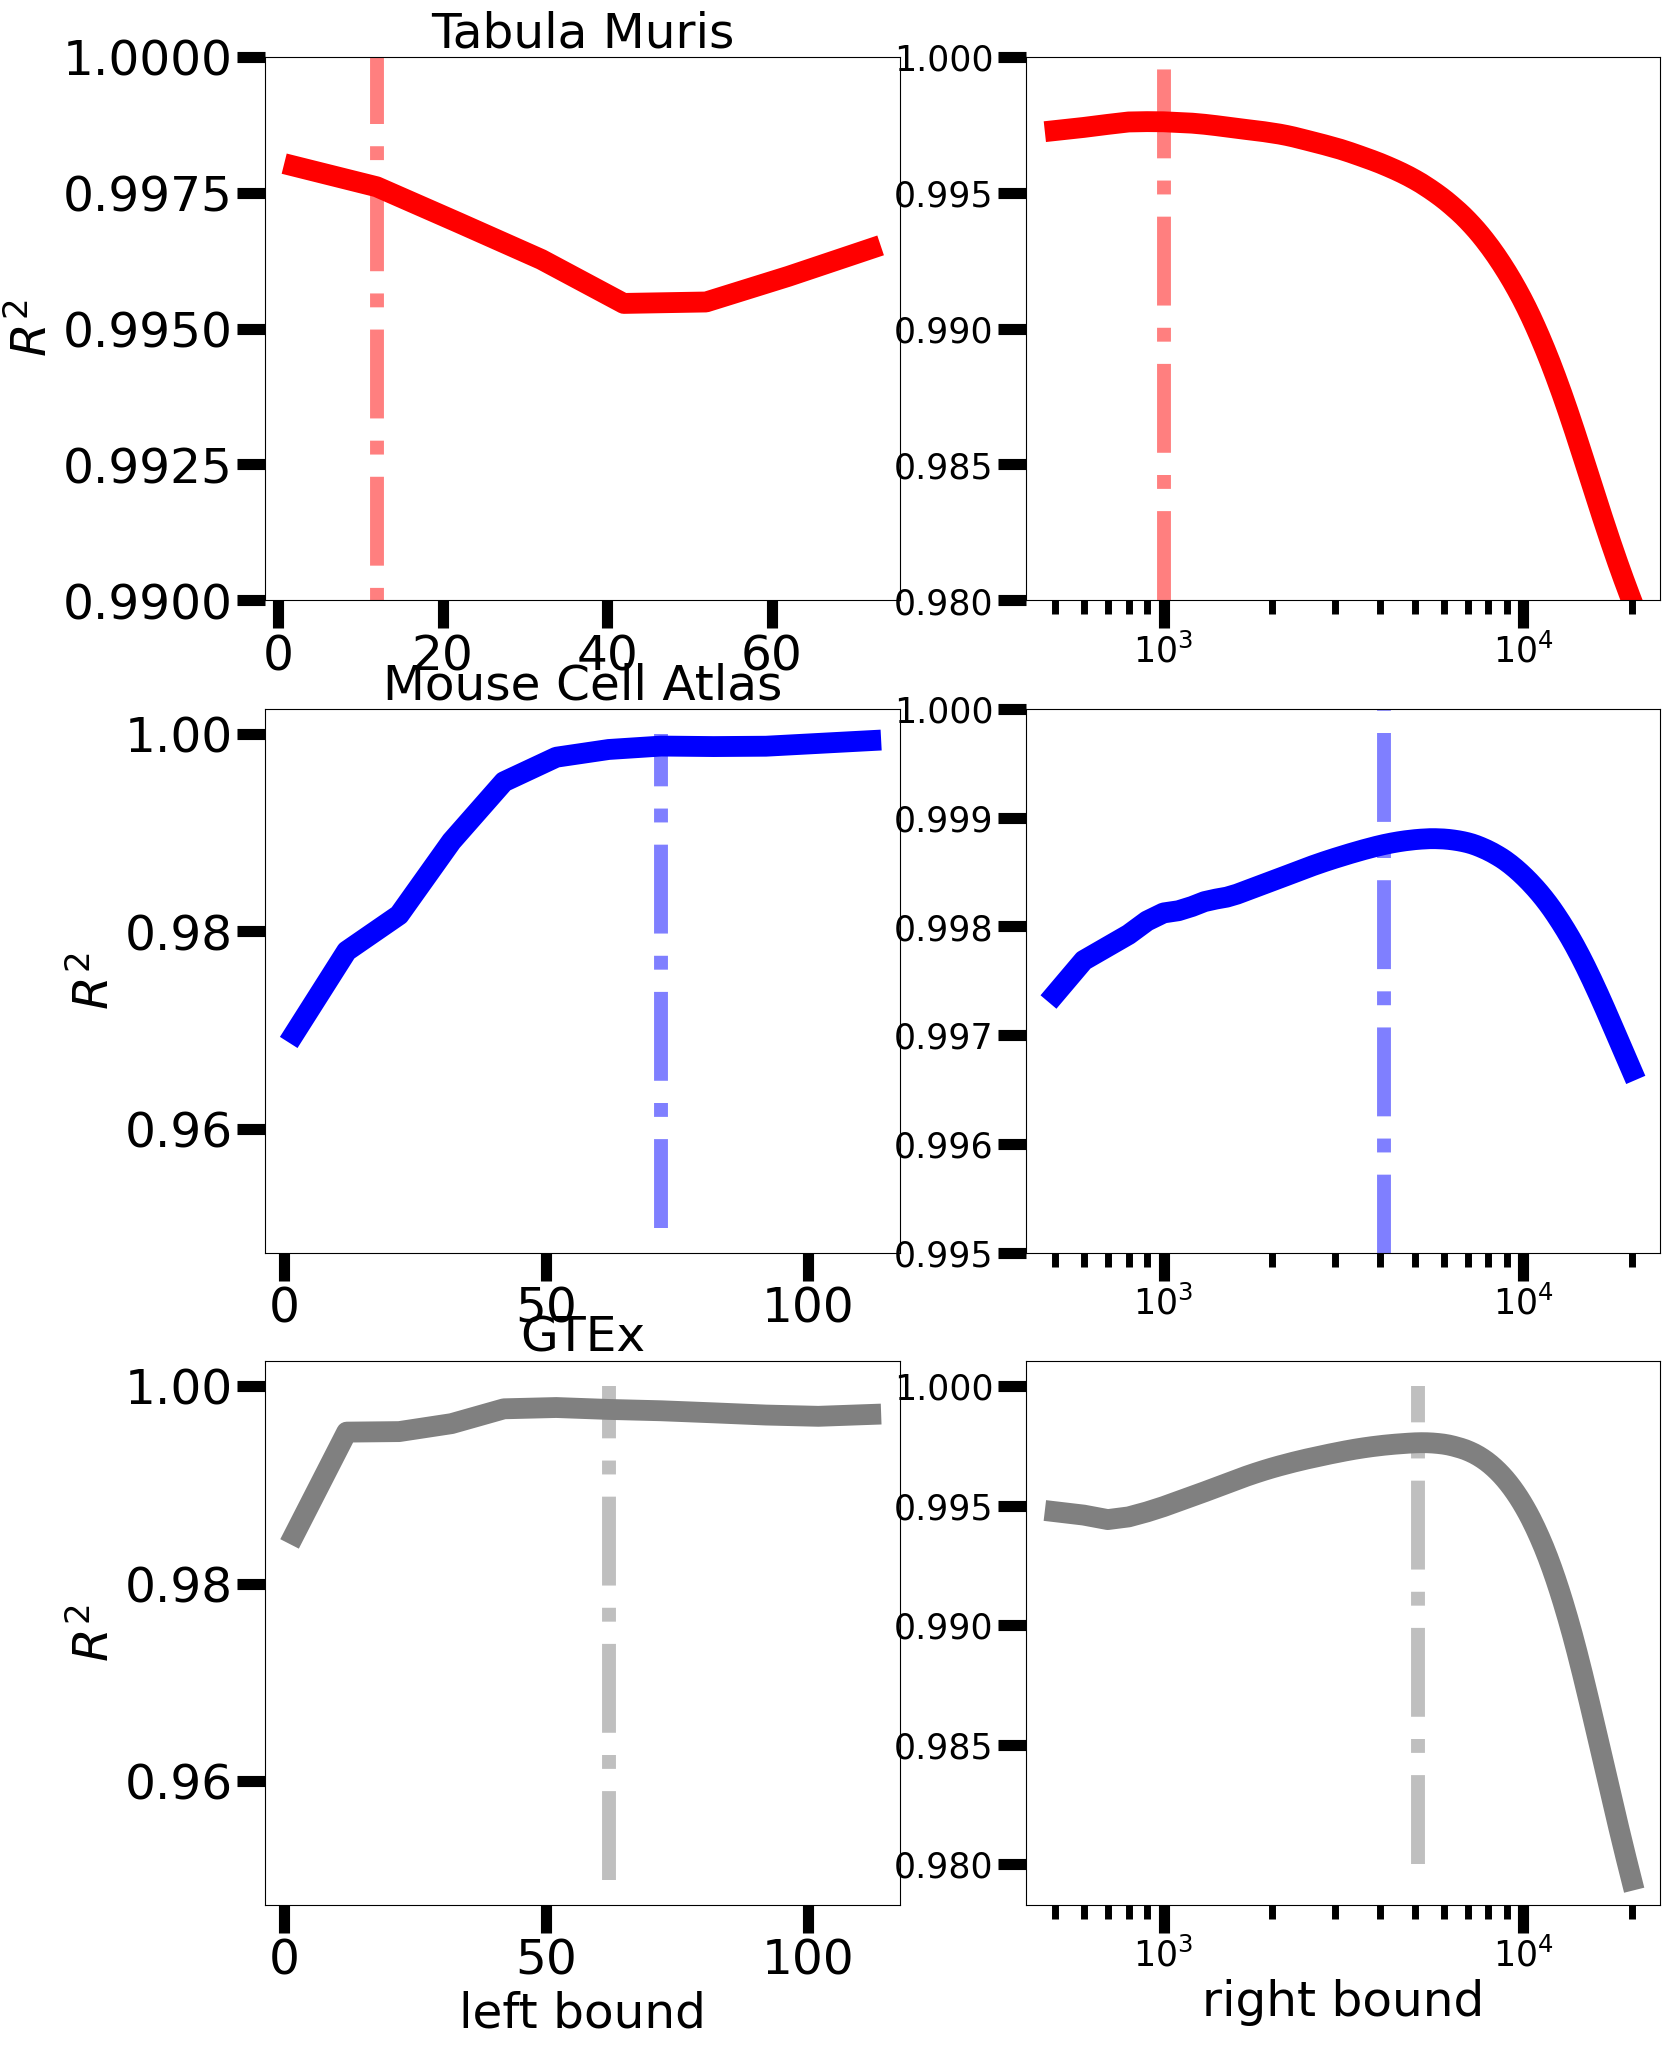

In [11]:
fig,ax = PyPlot.subplots(3, 2, figsize=(18,24))

for ((idataset,dataset), limits, sx_max, color) in zip(enumerate(["tm", "mca", "gtex"]),[(12,1000); (72,4100); (62,5100)],[82 121 121], ["red" "blue" "gray"])
    Rs = Matrix(CSV.read("rs_$(dataset).csv",DataFrames.DataFrame))
    
    lax = idataset
    rax= idataset+3
    
    ax[lax].plot(range(bounds["sx"]["min"],sx_max-1,step=bounds["sx"]["step"]), Rs[:,Int64((limits[2]-bounds["dx"]["min"])/bounds["dx"]["step"]+1)], lw=15, color=color)
    ax[rax].plot(range(bounds["dx"]["min"],bounds["dx"]["max"],step=bounds["dx"]["step"]), Rs[Int64((limits[1]-bounds["sx"]["min"])/bounds["sx"]["step"]+1),:], lw=15, color=color)
    
    ax[lax].vlines([limits[1]], 0.95, 1, colors=color, ls="-.", lw=10, alpha =0.5)
    ax[rax].vlines([limits[2]], 0.98, 1, colors=color, ls="-.", lw=10, alpha =0.5)
    
    ax[lax].set_ylabel(L"R^2", fontsize=35)

    ax[rax].set_xscale("log")
    
    ax[lax].tick_params(labelsize=35, width=8, length=20)
    ax[lax].tick_params(axis="both", which="minor", width=5, length=10)
    
    ax[rax].tick_params(labelsize=25, width=8, length=20)
    ax[rax].tick_params(axis="both", which="minor", width=5, length=10)

end

ax[3].set_xlabel("left bound", fontsize=35)
ax[6].set_xlabel("right bound", fontsize=35)

ax[1].set_title("Tabula Muris", fontsize=35)
ax[2].set_title("Mouse Cell Atlas", fontsize=35)
ax[3].set_title("GTEx", fontsize=35)


ax[1].set_ylim(0.99,1)
ax[4].set_ylim(0.98,1)
ax[5].set_ylim(0.9950,1)


PyPlot.show()
fig.savefig("bounds_panel.pdf")

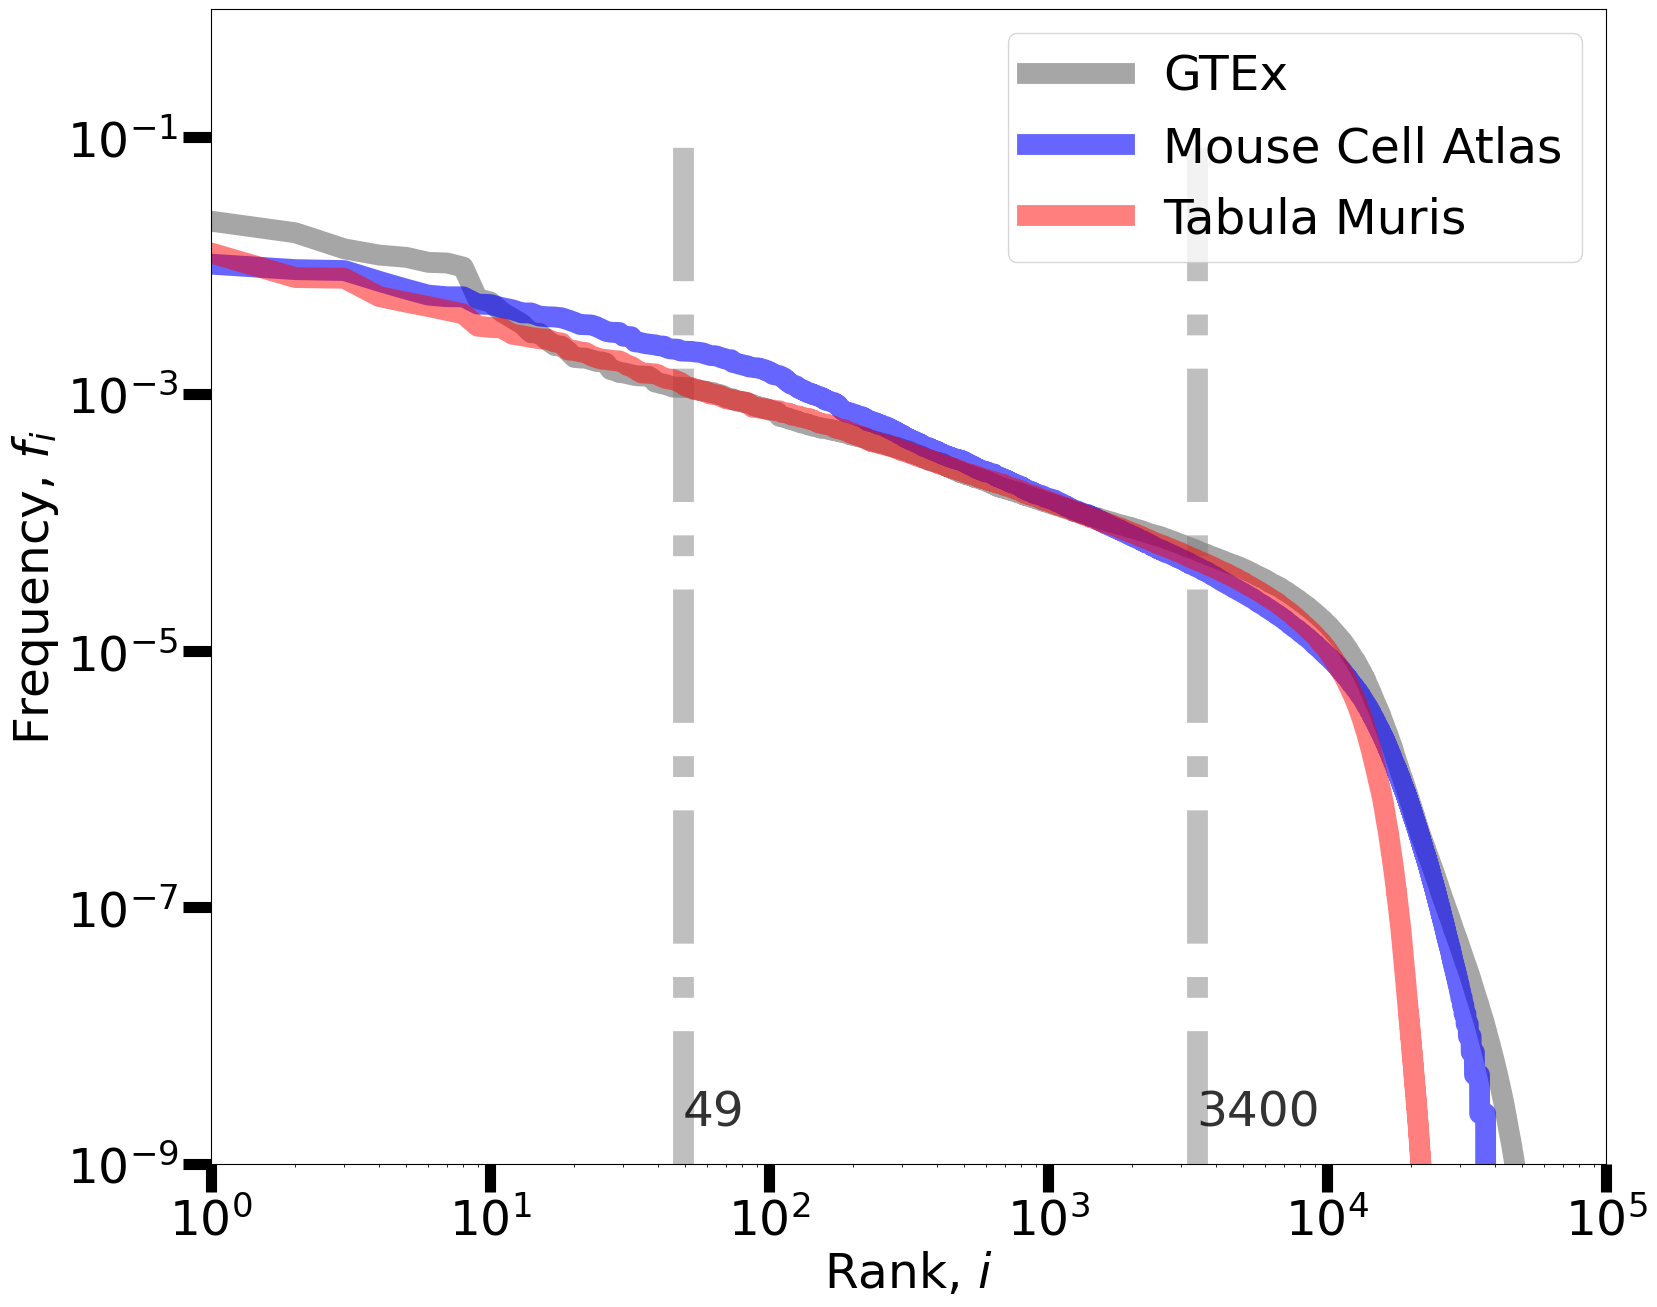

In [12]:
limits = (Int64(round(mean([12 72 62]))), Int64(round(mean([1000 4100 5100])))) #tm mca gtex

fig, ax = PyPlot.subplots(figsize=(18,15))

ax.plot(f_gtex, label="GTEx", lw=15, color="gray", alpha=0.7)
ax.plot(f_mca, label="Mouse Cell Atlas", lw=15, color="blue", alpha=0.6)
ax.plot(f_tm, label="Tabula Muris", lw=15, color="red", alpha=0.5)

X = collect(1:1e5)

ax.vlines([limits[1] limits[2]], 1e-9, 1e-1, colors="gray", ls="-.", lw=15, alpha =0.5)
ax.annotate("$(limits[1])", (limits[1],2e-9), fontsize=35, alpha=0.8)
ax.annotate("$(limits[2])", (limits[2],2e-9), fontsize=35, alpha=0.8)


ax.legend(fontsize=35)
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel(L"Rank, $i$", fontsize=35)
ax.set_ylabel(L"Frequency, $f_i$", fontsize=35)

ax.tick_params(labelsize=35, width=8, length=20)

ax.set_xlim(1,1e5)
ax.set_ylim(1e-9,1e0)
show()

fig.savefig("zipf_alldatasets_fit_avg.pdf")

### Save first regime for GO

The results of the GeneOntologies analyses are well described in the paper

In [34]:
first_regime = DataFrames.DataFrame()
first_regime.mca = sort(CSV.read("A_mca.dat",DataFrames.DataFrame), 2, rev=true).Column1[1:limits[1]]
first_regime.tm = sort(CSV.read("A_tm.dat",DataFrames.DataFrame), 2, rev=true).Column1[1:limits[1]]
first_regime.gtex = sort(CSV.read("A_gtex.dat",DataFrames.DataFrame), 2, rev=true).ensg[1:limits[1]]
CSV.write("first_regime.csv",first_regime)

"first_regime.csv"

In [35]:
fit = curve_fit(fit_func_exp, X[3400:length(f_mca)], f_mca[3400:end], [1e-1, 1e-3])
popt_exp, pcov_exp = (coef(fit), estimate_covar(fit))

([9.643442170490088e-5, 0.00024068098160088248], [2.3772661301466958e-15 3.932848788412567e-15; 3.932848788412567e-15 7.444143657137287e-15])

In [44]:
df_nc = CSV.read("MGImarkerQuery_20200914_050053.txt", DataFrames.DataFrame, delim="\t");
names(df_nc)

┌ Warning: thread = 1 warning: only found 10 / 11 columns around data row: 2. Filling remaining columns with `missing`
└ @ CSV /opt/julia/packages/CSV/la2cd/src/file.jl:603
┌ Warning: thread = 1 warning: only found 10 / 11 columns around data row: 3. Filling remaining columns with `missing`
└ @ CSV /opt/julia/packages/CSV/la2cd/src/file.jl:603
┌ Warning: thread = 1 warning: only found 10 / 11 columns around data row: 4. Filling remaining columns with `missing`
└ @ CSV /opt/julia/packages/CSV/la2cd/src/file.jl:603
┌ Warning: thread = 1 warning: only found 10 / 11 columns around data row: 5. Filling remaining columns with `missing`
└ @ CSV /opt/julia/packages/CSV/la2cd/src/file.jl:603
┌ Warning: thread = 1 warning: only found 10 / 11 columns around data row: 6. Filling remaining columns with `missing`
└ @ CSV /opt/julia/packages/CSV/la2cd/src/file.jl:603
┌ Warning: thread = 1 warning: only found 10 / 11 columns around data row: 7. Filling remaining columns with `missing`
└ @ CSV /opt/jul

11-element Array{String,1}:
 "Chromosome"
 "Start"
 "End"
 "cM"
 "strand GRCm38"
 "MGI ID"
 "Feature Type"
 "Symbol"
 "Name"
 "Column10"
 "Column11"

In [45]:
nc = df_nc[df_nc[:,"Feature Type"] .!= "protein coding gene","Symbol"];

In [47]:
f_mca = Tacos.load_pickle("mca/data_all.pkl")["freq"]
mask = reshape(1 .- f_mca.index.isin(nc),(length(f_mca)))
f_mca_pc = [v for v in f_mca][mask .== 1];
f_mca_pc = sort(f_mca_pc./sum(f_mca_pc), rev=true);
f_mca = sort(f_mca./sum(f_mca), rev=true);

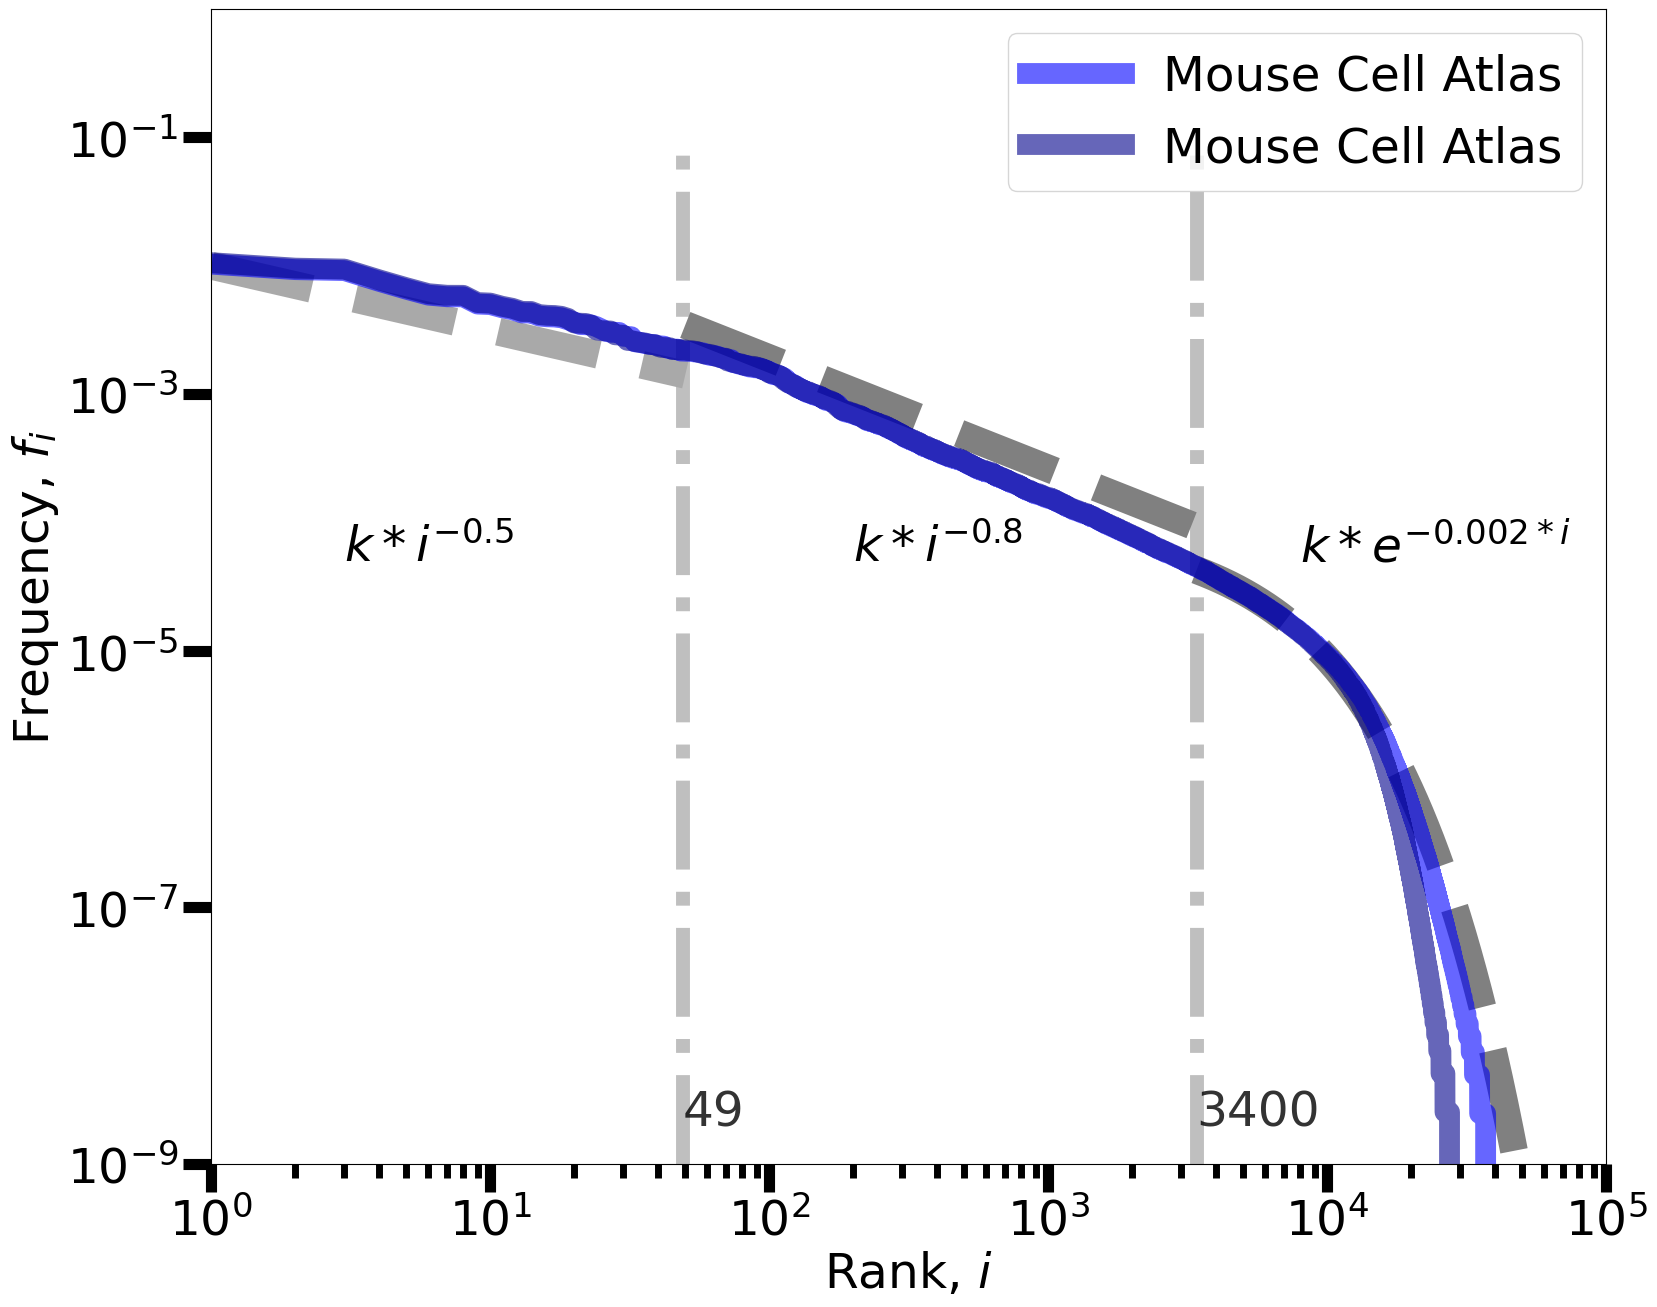

In [48]:
fig, ax = PyPlot.subplots(figsize=(18,15))

X = collect(1:1e5)

#ax.plot(X,[1e-1*x^-0.86 for x in X], lw=20, ls="--", color="gray")
ax.plot(X[1:50],[1e-2*x^-0.5 for x in X[1:50]], lw=20, ls="--", color="darkgray")
ax.plot(X[50:3400],[1e-1*x^-0.86 for x in X[50:3400]], lw=20, ls="--", color="gray")
ax.plot(X[3400:end],fit_func_exp(X[3400:end], popt_exp), lw=20, ls="--", color="gray")


#ax.plot(f_gtex, label="GTEx", lw=15, color="gray", alpha=0.7)
ax.plot(f_mca, label="Mouse Cell Atlas", lw=15, color="blue", alpha=0.6)
ax.plot(f_mca_pc, label="Mouse Cell Atlas", lw=15, color="darkblue", alpha=0.6)
#ax.plot(f_tm, label="Tabula Muris", lw=15, color="red", alpha=0.5)

ax.vlines([limits[1]], 1e-9, 1e-1, colors="gray", ls="-.", lw=10, alpha =0.5)
ax.vlines([limits[2]], 1e-9, 1e-1, colors="gray", ls="-.", lw=10, alpha =0.5)

ax.annotate(L"$k*i^{-0.5}$", (3e0,0.5e-4), fontsize=35)
ax.annotate(L"$k*i^{-0.8}$", (2e2,0.5e-4), fontsize=35)
ax.annotate(L"$k*e^{-0.002*i}$", (0.8e4,0.5e-4), fontsize=35)

ax.annotate("$(limits[1])", (limits[1],2e-9), fontsize=35, alpha=0.8)
ax.annotate("$(limits[2])", (limits[2],2e-9), fontsize=35, alpha=0.8)

ax.legend(fontsize=35)
ax.set_yscale("log")
ax.set_xscale("log")

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(axis="both",which="minor", width=5, length=10)

ax.set_xlabel(L"Rank, $i$", fontsize=35)
ax.set_ylabel(L"Frequency, $f_i$", fontsize=35)

ax.set_xlim(1,1e5)
ax.set_ylim(1e-9,1e0)
show()

fig.savefig("zipf_mca.pdf")

## CV^2 

In [49]:
data_source = "mca"
data = Tacos.load_pickle("$(data_source)/data_all.pkl");

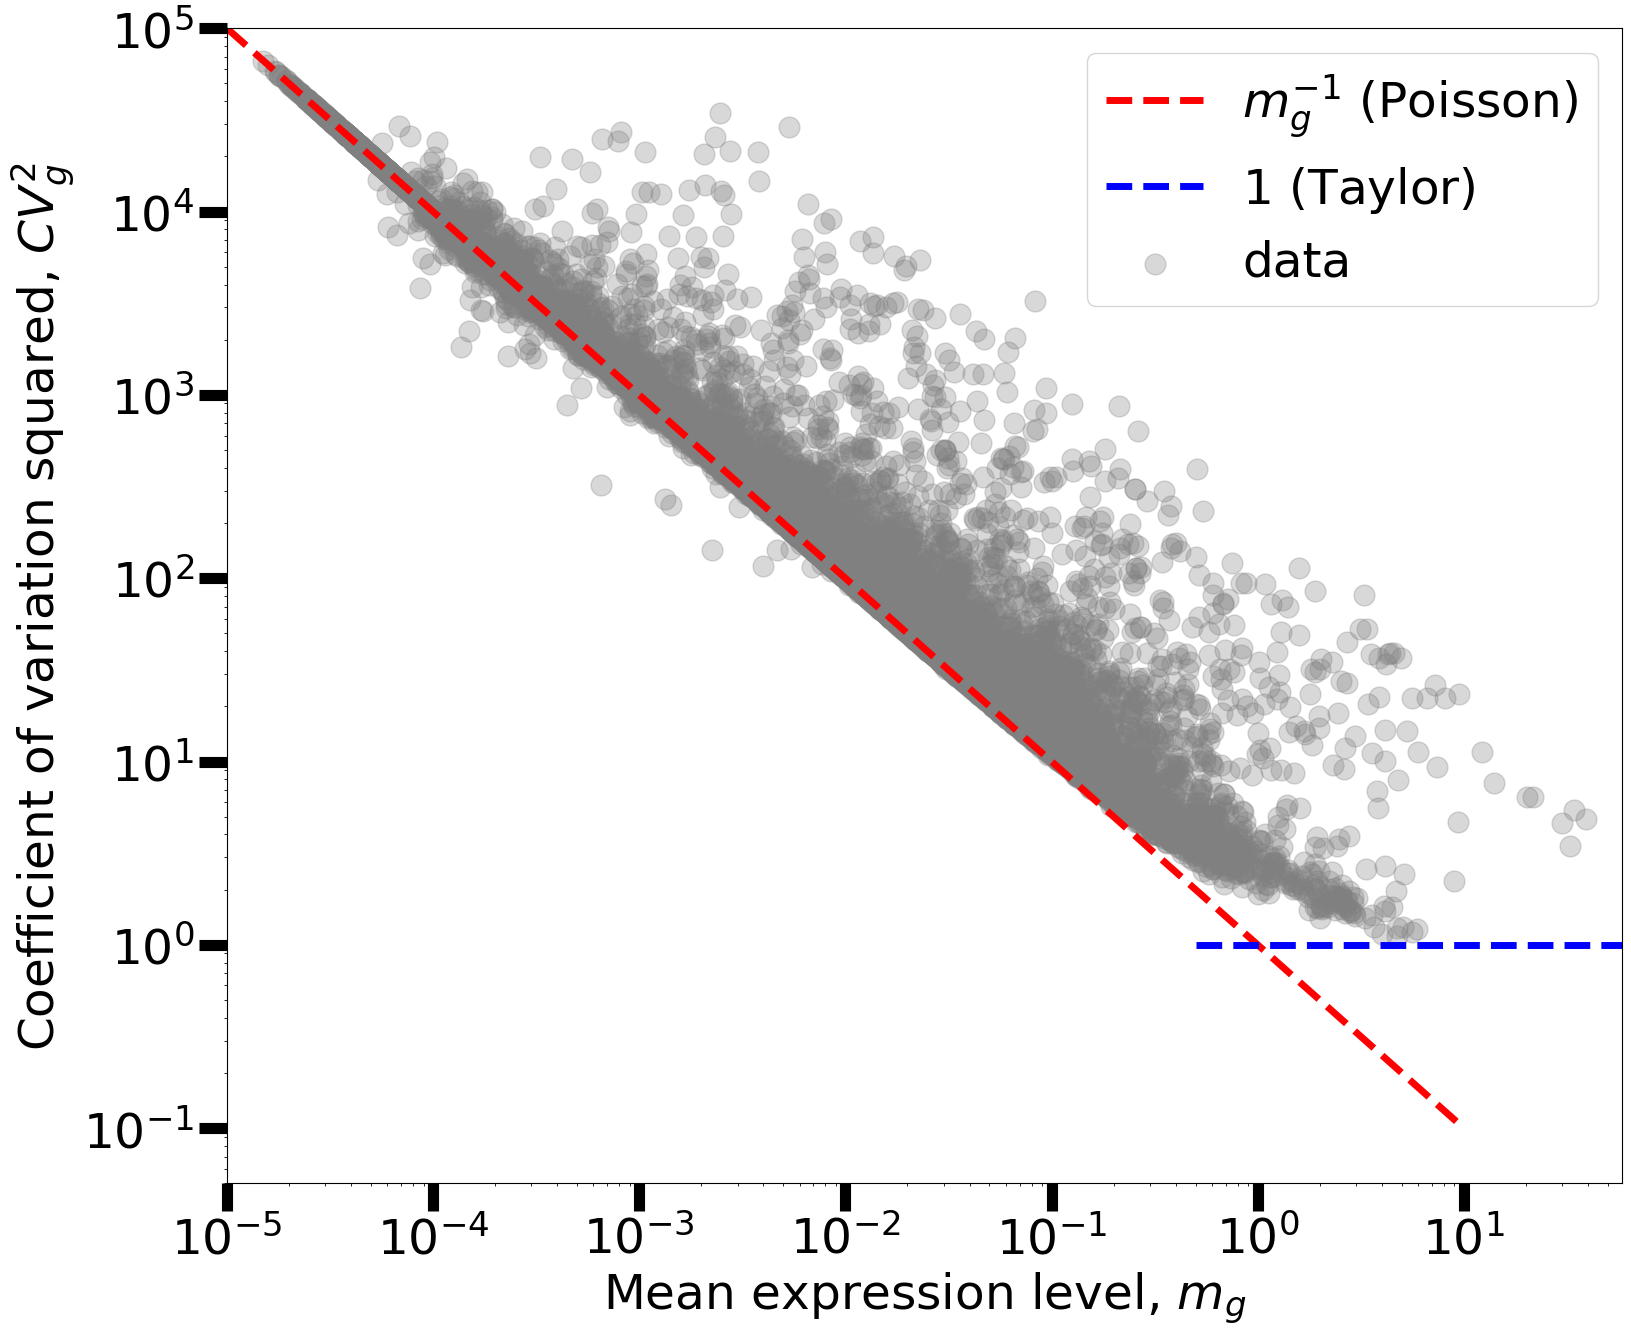

In [50]:
fig, ax = PyPlot.subplots(figsize=(18,15))

means = [m for (m,v) in zip(data["means"], data["var"]) if v>1e-6]
vars = [v for v in data["var"] if v>1e-6]

ax.scatter(means, [v/m/m for (m,v) in zip(means, vars)], c="gray", alpha=0.3, s=225, label="data")

x = range(1e-5,10, length=10)
ax.plot(x,[1/x_i for x_i in x], lw=5, color="red", ls="--", label=L"$m_g^{-1}$ (Poisson)")

x = range(0.5,5e5, length=10)
ax.plot(x,[1 for _ in x], lw=5, color="blue", ls="--", label=L"$1$ (Taylor)")

ax.set_ylabel(L"Coefficient of variation squared, $CV^2_g$", fontsize=35)
ax.set_xlabel(L"Mean expression level, $m_g$", fontsize=35)

ax.set_xscale("log")
ax.set_yscale("log")

ax.tick_params(labelsize=35, width=8, length=20)

ax.set_xlim(1e-5, maximum(means)*1.5)
ax.set_ylim(5e-2, 1e5)

ax.legend(fontsize=35)

PyPlot.show()
fig.savefig("cv2_mean_$(data_source).pdf")

# Occurrency distribution of all the data. Aka the global U

In [51]:
data = Tacos.load_pickle("mca/data_all.pkl");

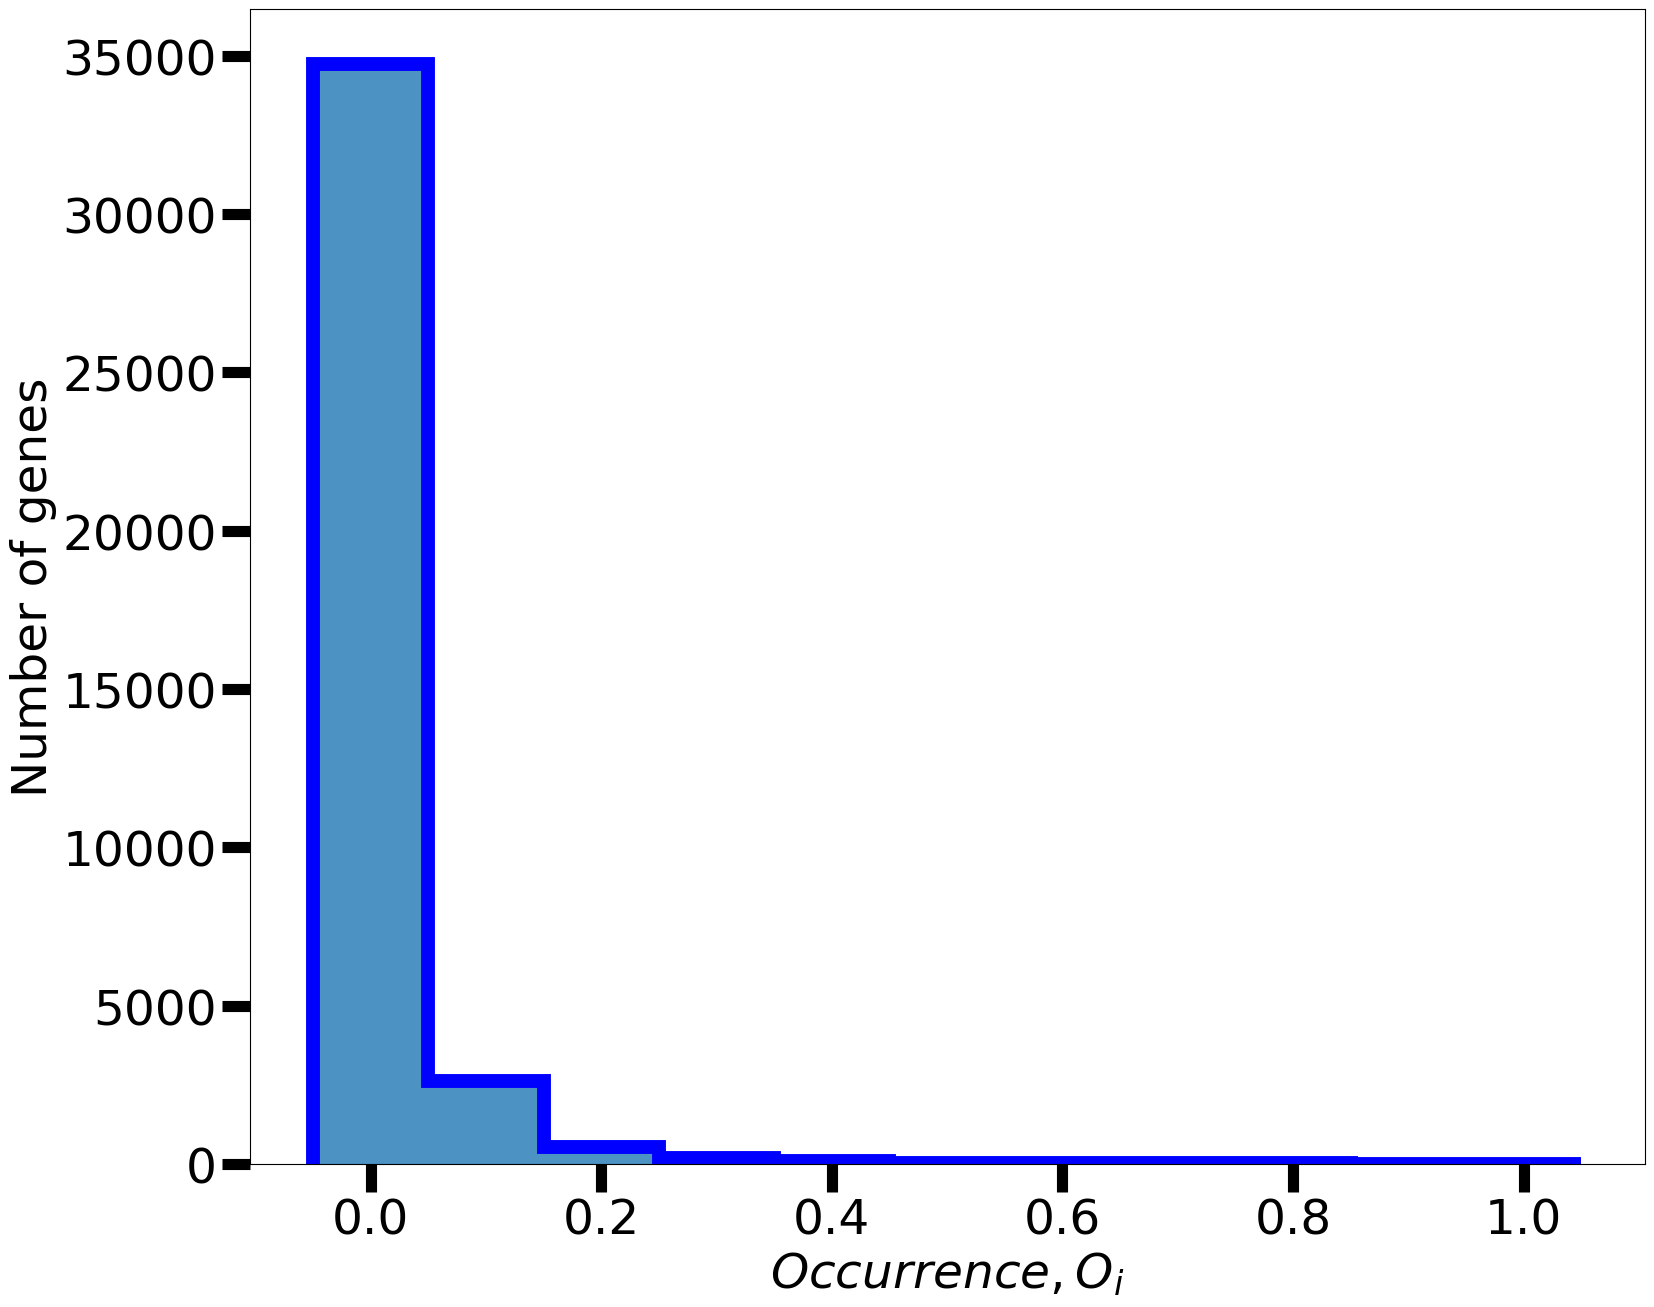

In [52]:
fig, ax = PyPlot.subplots(figsize=(18,15))

bins = -0.05:0.1:1.05

bin_counts, bin_edges = ax.hist(data["O"].values, color="blue", lw=10, histtype="step", bins=bins)

x_bins = (bin_edges[1:length(bin_edges)-1]+bin_edges[2:length(bin_edges)])/2
ax.hist(x_bins, weights=bin_counts, bins=bins, histtype="stepfilled", lw=0, alpha=0.8)

ax.set_xlabel(L"Occurrence, O_i", fontsize=35)
ax.set_ylabel("Number of genes", fontsize=35)

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(which="minor", width=6, length=10)

PyPlot.show()
fig.savefig("U_mca.pdf")

# UMI count histogram

In [53]:
data = Tacos.load_pickle("mca/data_all.pkl");

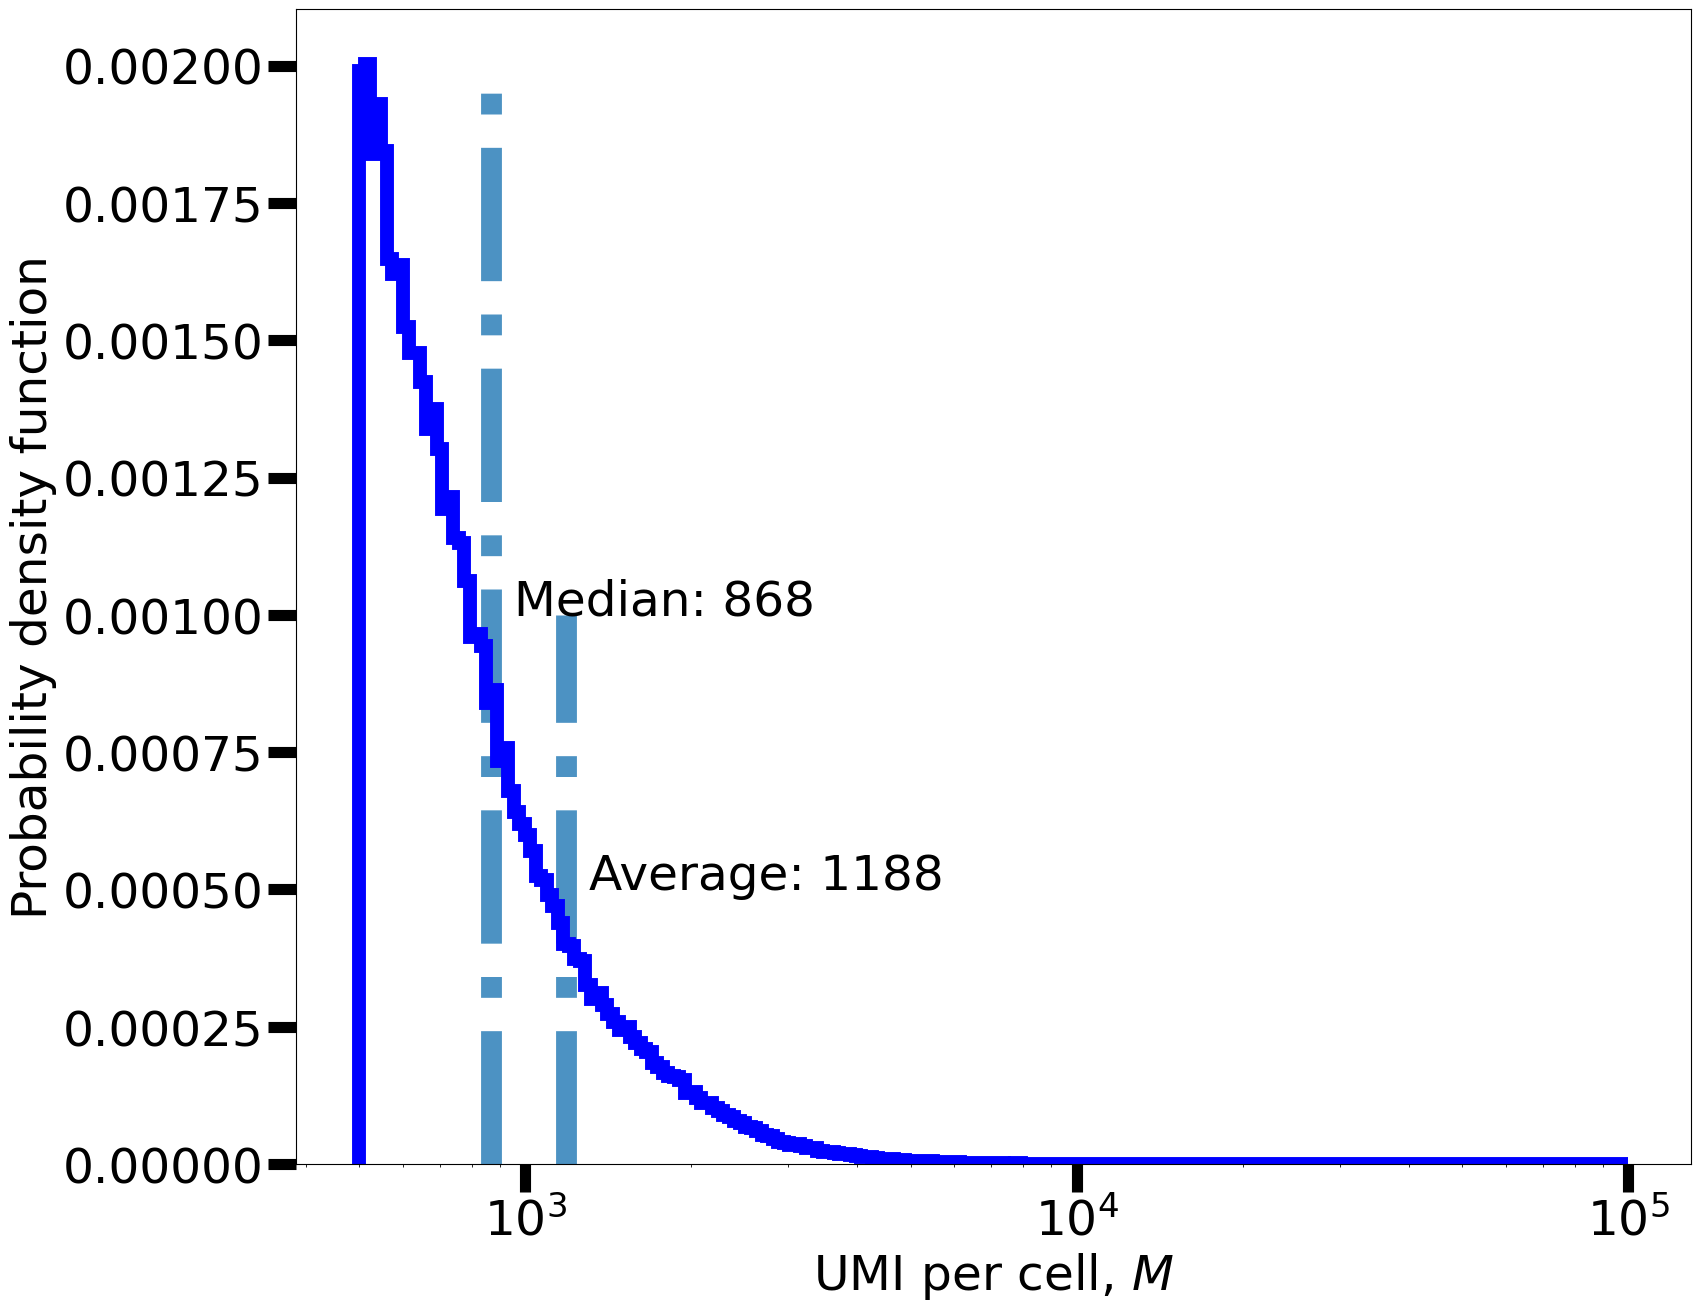

[0.3205828080811257, 0.004058314150502399, 1000.0]


In [54]:
fig, ax = PyPlot.subplots(figsize=(18,15))

x_bins = sort!([10^i for i in log10(500):0.01:5])
bin_counts, bin_edges = ax.hist(data["M"], density=true, color="blue", histtype="step", lw=10, bins=x_bins)

m = mean(data["M"])
ax.vlines([m], 0,1e-3, lw=15, alpha=0.8,  ls="-.")
ax.annotate("Average: $(@sprintf("%.0f", m))", (m*1.1,5e-4), fontsize=35)

m = median(data["M"])
ax.vlines([m], 0,2e-3, lw=15, alpha=0.8,  ls="-.")
ax.annotate("Median: $(@sprintf("%.0f", m))", (m*1.1,10e-4), fontsize=35)

x_bins=(bin_edges[1:length(bin_edges)-1]+bin_edges[2:length(bin_edges)])/2

scaled_pois = function(X, par)
    mu = par[1]
    C = par[2]
    a = par[3]
    d = Poisson(mu)
    return C*[pdf(d,round(Int, x/a::Float64)) for x in X]
end

fit_pois = curve_fit(scaled_pois, x_bins, bin_counts, [0.5, 0.1, 1000])
popt = coef(fit_pois)
println(popt)

#ax.plot(x_bins, scaled_pois(x_bins, popt), lw=10, color="orange")

ax.set_xlabel(L"UMI per cell, $M$", fontsize=35)
ax.set_ylabel("Probability density function", fontsize=35)

ax.tick_params(labelsize=35, width=8, length=20)

ax.set_xscale("log")
#ax.set_yscale("log")

#ax.set_xlim(1,3e8)

#ax.legend(fontsize=22)

PyPlot.show()
fig.savefig("M_hist_mca.pdf")

# Pdf of Frequencies

In [3]:
data = Tacos.load_pickle("mca/data_all.pkl");

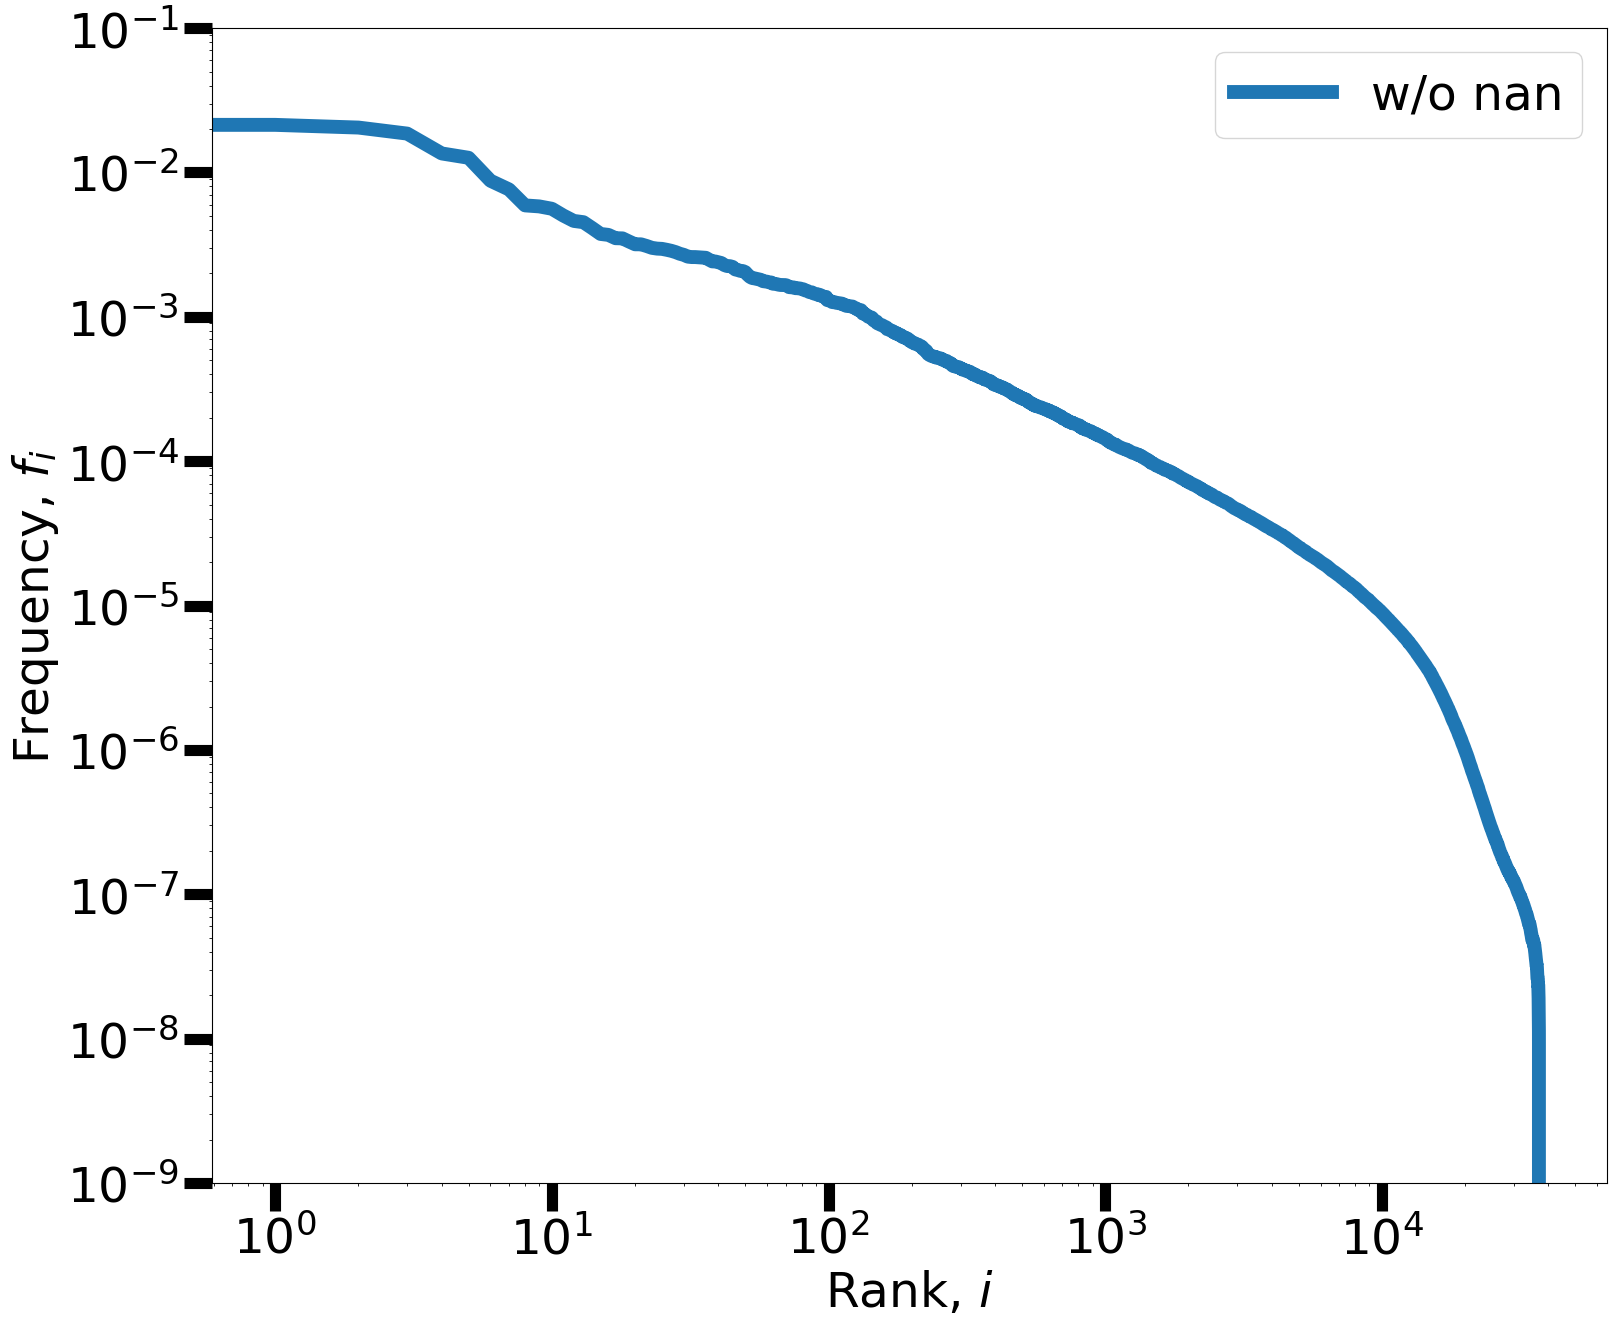

In [4]:
fig, ax = PyPlot.subplots(figsize=(18,15))


#ax.plot(sort!(data["freq"].values,rev=true), label="nan=0", lw=10)
ax.plot(sort!(data["means"].values/sum(filter(!isnan, data["means"].values)),rev=true), label="w/o nan", lw=10)
#ax.plot(sort!(data["means_nonzero"].values/sum(filter(!isnan, data["means_nonzero"].values)),rev=true), ms=50, label="m0", lw=10, color="gray")

ax.set_xscale("log")
ax.set_yscale("log")

ax.legend(fontsize=35)
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_ylim(1e-9,1e-1)

ax.tick_params(labelsize=35, width=8, length=20)
ax.set_xlabel(L"Rank, $i$", fontsize=35)
ax.set_ylabel(L"Frequency, $f_i$", fontsize=35)
fig.savefig("pdf_freq_mca.pdf")

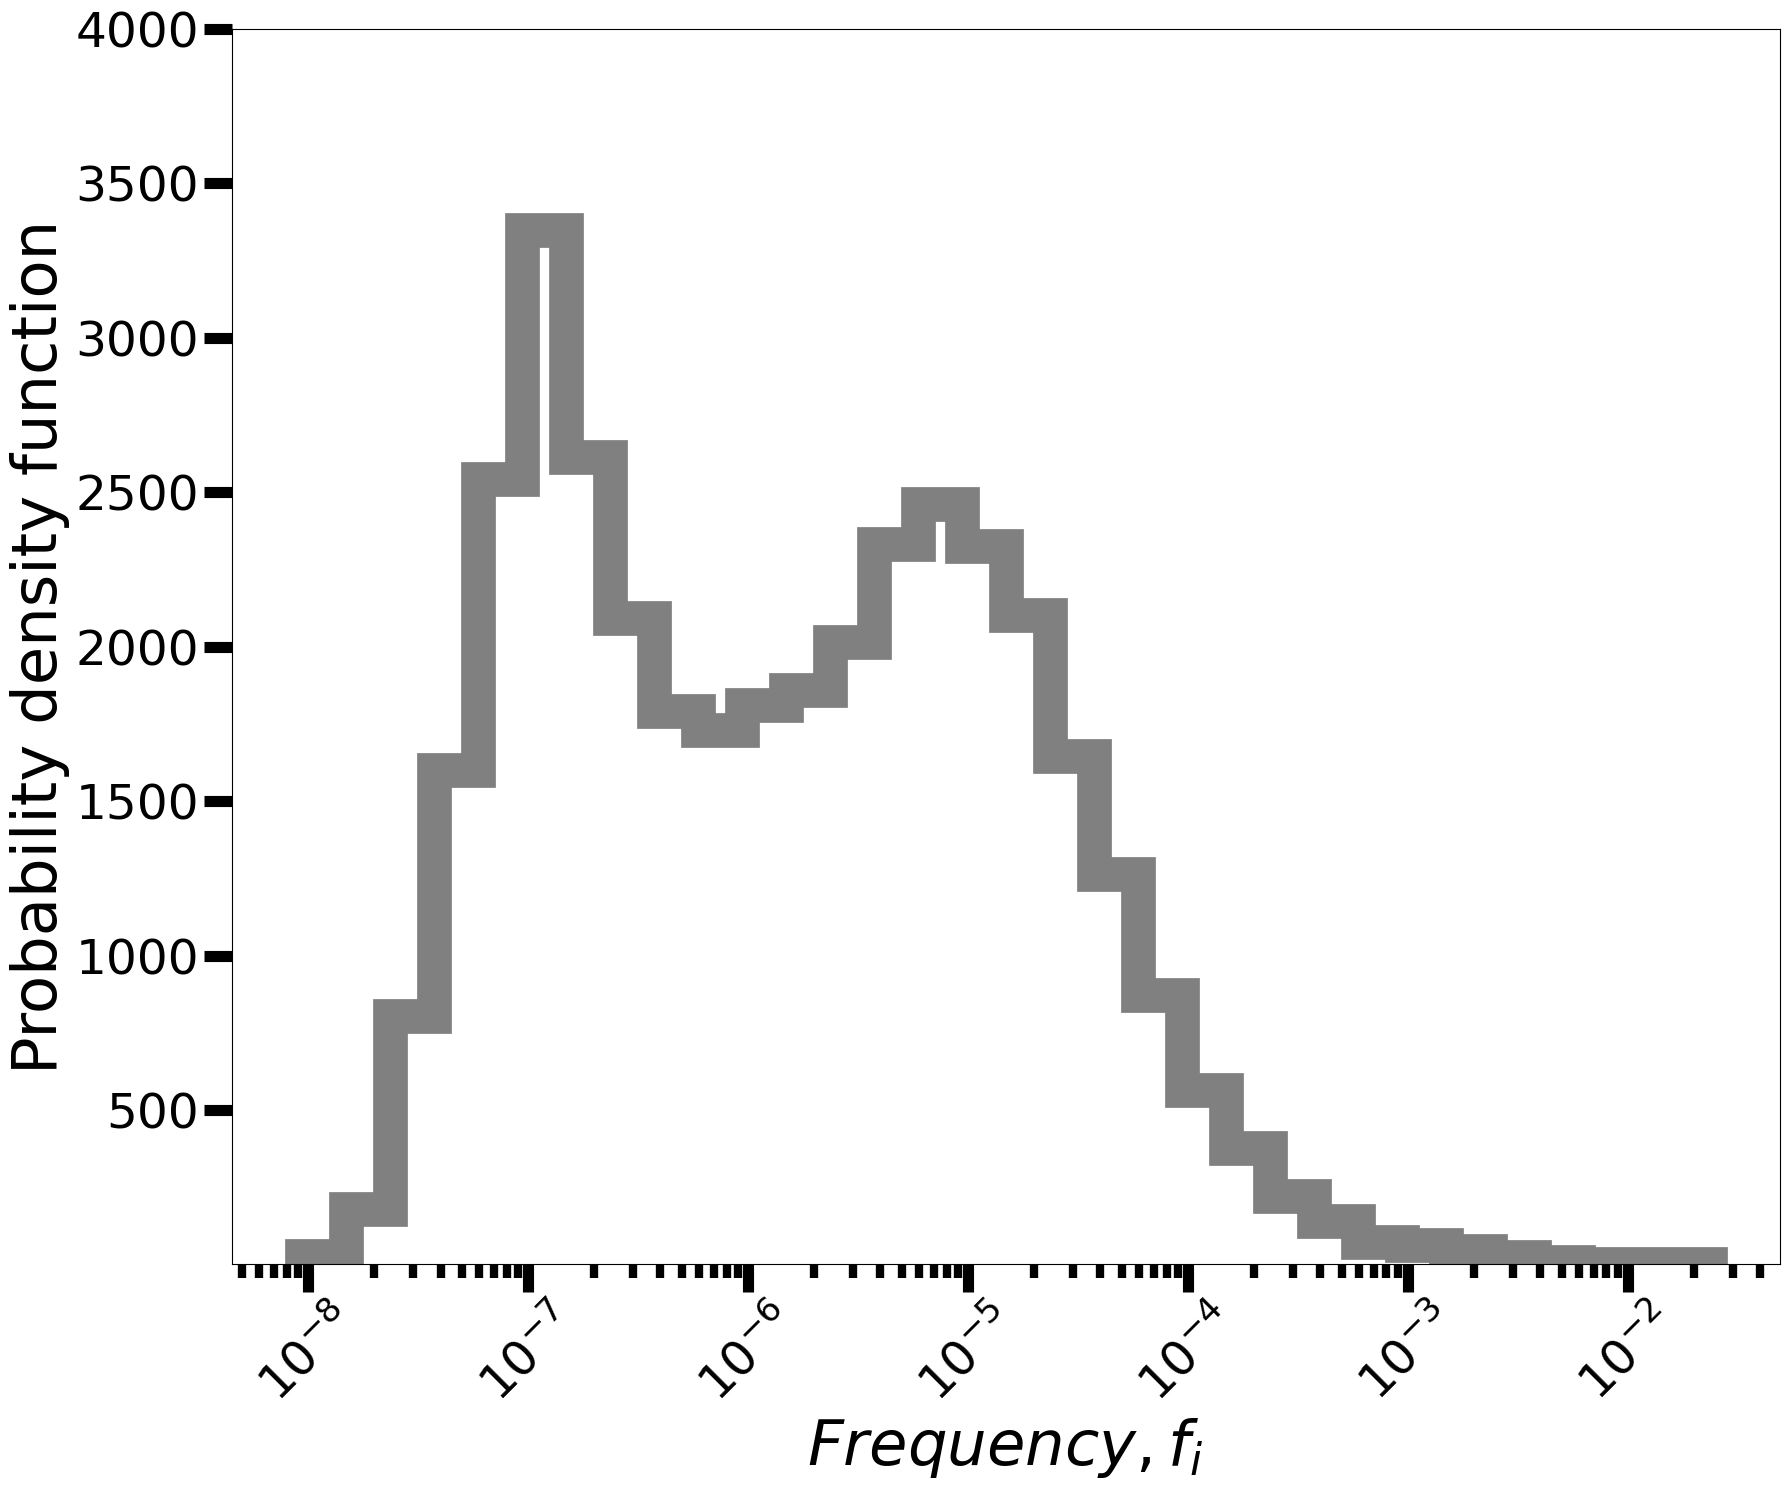

In [6]:
fig, ax = PyPlot.subplots(figsize=(18,15))

f = filter(!isnan, data["means"].values)
f = f / sum(f)
#f = data["freq"].values
f = f[f .> 0]
#f = f[f .< 5e-3]


#x_bins = sort!([10. ^ -x for x in 1:0.2:8])
x_bins = sort!([10. ^ x for x in log10(minimum(f)):0.2:log10(maximum(f))])
bin_counts, bin_edges = ax.hist(f, bins=x_bins, density=false, color="gray", histtype="step", lw=25)

ax.set_xlabel(L"Frequency, f_i", fontsize=45)
ax.set_ylabel("Probability density function", fontsize=45)

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(which="minor", width=6, length=10)
ax.tick_params(axis="x", which="both", rotation=45)

#kde_values = pdf(kde(f), x_bins)
#ax.plot(x_bins,kde_values/sum(kde_values)*30000)

ax.set_xscale("log")
#ax.set_yscale("log")

ax.set_ylim(5e-1,4e3)

PyPlot.tight_layout()
PyPlot.show()
fig.savefig("freq_pdf_mca.pdf")
fig.savefig("freq_pdf_mca.eps")

# Analyse single organ

In [58]:
tissue = "Bone-Marrow_c-kit"

data = Dict()
data["data"]=Tacos.load_pickle("mca/data_$(tissue)_data.pkl")
data["mazzolini"]=Tacos.load_pickle("mca/data_$(tissue)_mazzolini.pkl");
#data["null_1"]=load_pickle("data_$(tissue)_null_1.pkl")

This is not shown in the paper. It is a check that sampled and true frequency distributios are actually the same

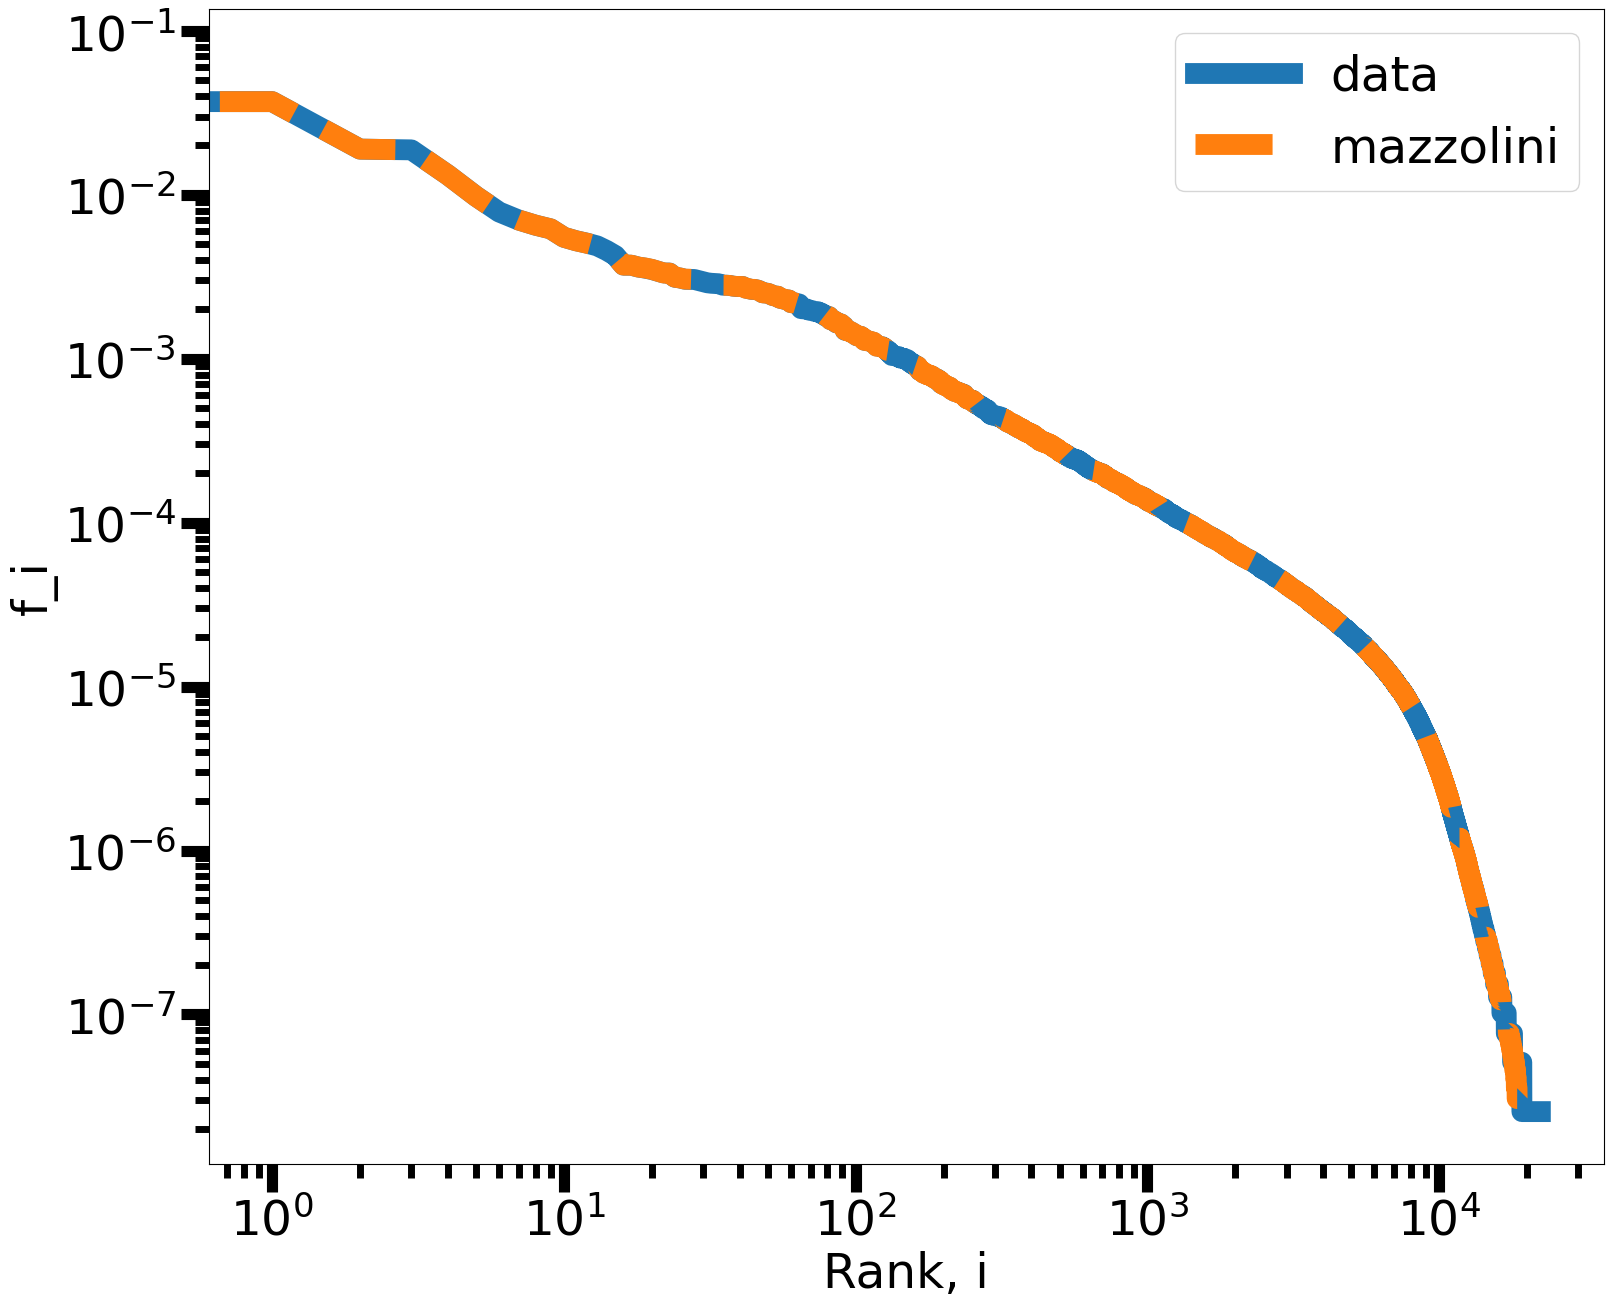

In [59]:
fig, ax = PyPlot.subplots(figsize=(18,15))
ax.plot(sort(data["data"]["freq"].values, rev=true), lw=15, label="data")
ax.plot(sort(filter(!isnan,data["mazzolini"]["freq"]), rev=true), lw=15, ls="--", label="mazzolini")

ax.legend(fontsize=35)
ax.set_yscale("log")
ax.set_xscale("log")

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(which="minor", labelsize=35, width=5, length=10)

ax.set_xlabel("Rank, i", fontsize=35)
ax.set_ylabel("f_i", fontsize=35)
show()

fig.savefig("null_zipf.pdf")

## Heaps

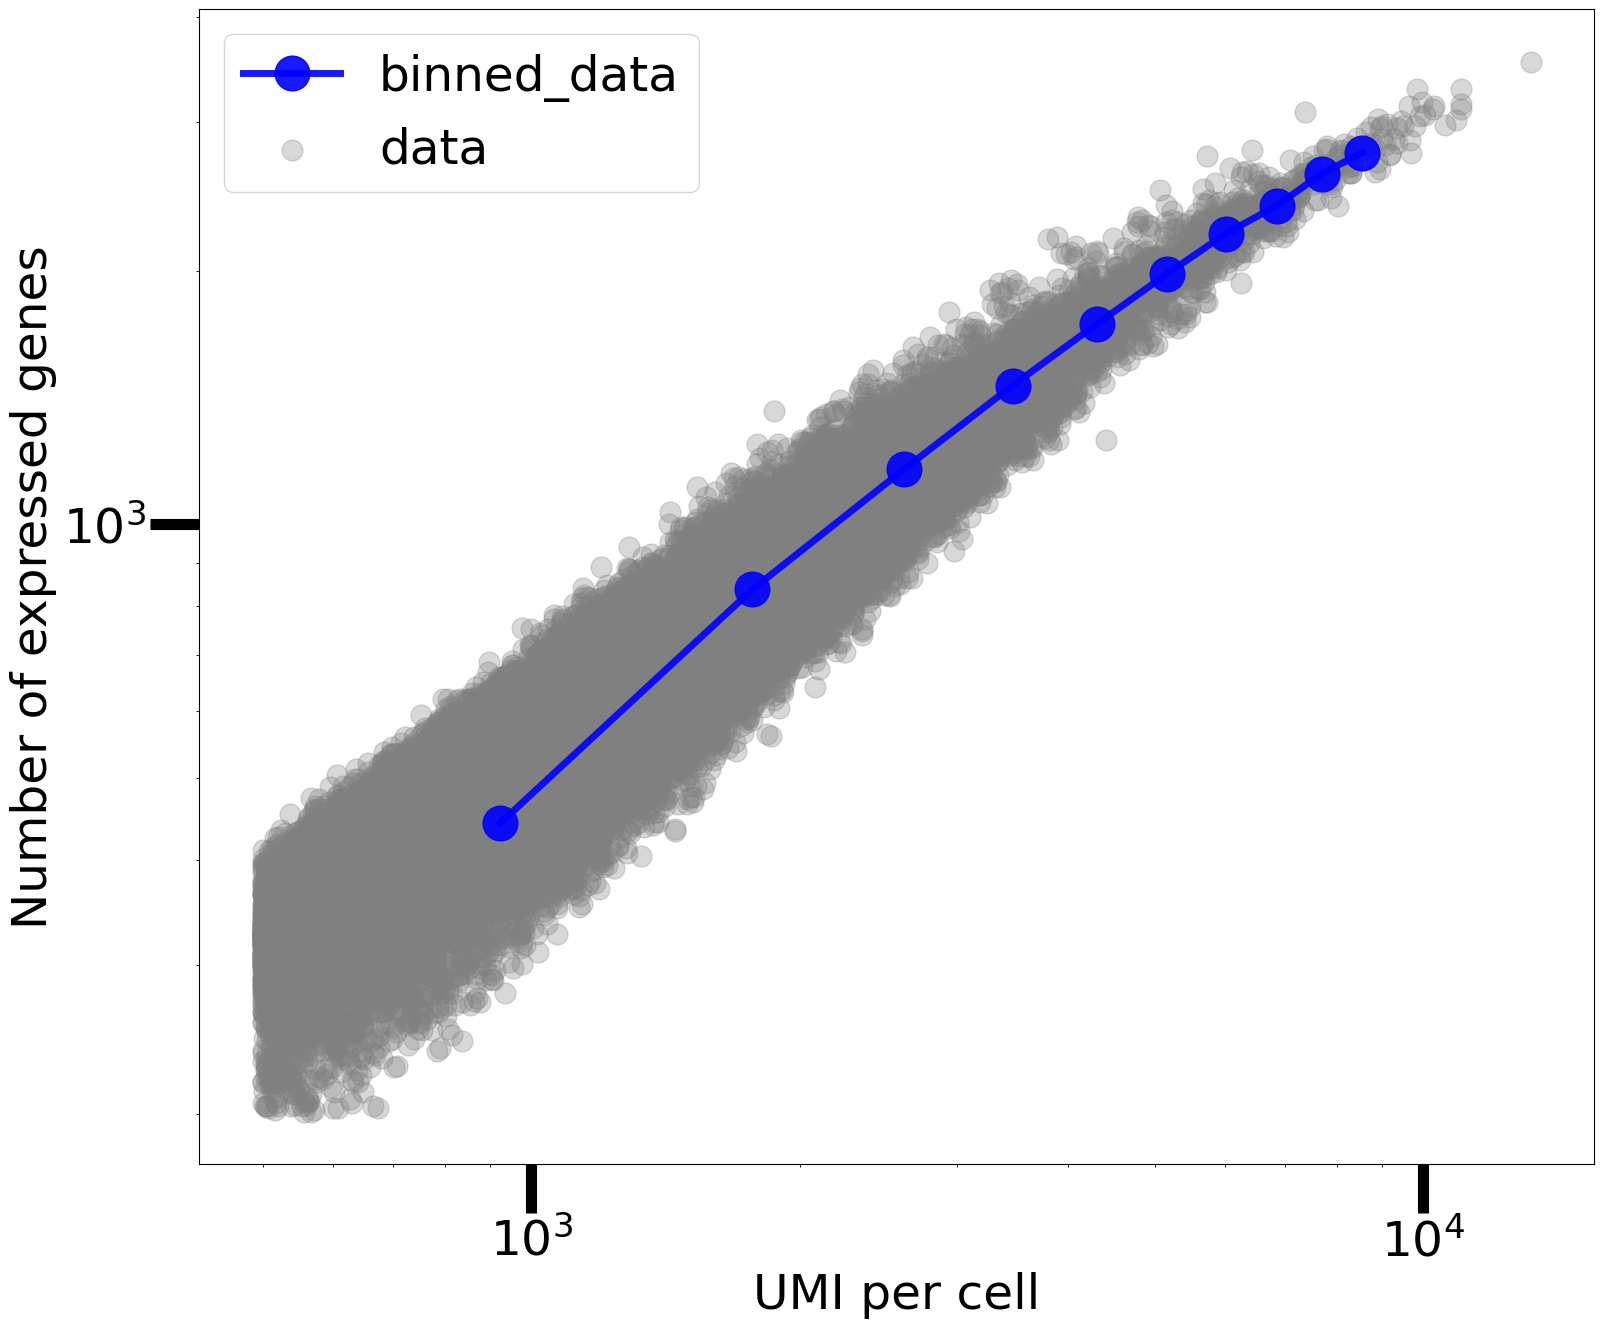

In [60]:
loglog=true

fig, ax = PyPlot.subplots(figsize=(18,15))

ax.scatter(data["data"]["M"], data["data"]["diffWords"], c="gray", alpha=0.3, s=225, label="data")
bin_means, bin_edges = scipy_stats.binned_statistic(data["data"]["M"], data["data"]["diffWords"], bins=15)

x_bins = (bin_edges[1:10] + bin_edges[2:11])/2
ax.plot(x_bins, bin_means[1:10], c="blue", alpha=0.9, lw=5, ms=25, marker="o", label="binned_data")


ax.set_xlabel("UMI per cell", fontsize=35)
ax.set_ylabel("Number of expressed genes", fontsize=35)

if loglog
    ax.set_xscale("log")
    ax.set_yscale("log")
end

ax.legend(fontsize=35)

ax.tick_params(labelsize=35, width=8, length=35)

PyPlot.show()
if loglog
    fig.savefig("heaps_boneMarrow_MCA_loglog.pdf")
else
    fig.savefig("heaps_boneMarrow_MCA.pdf")
end

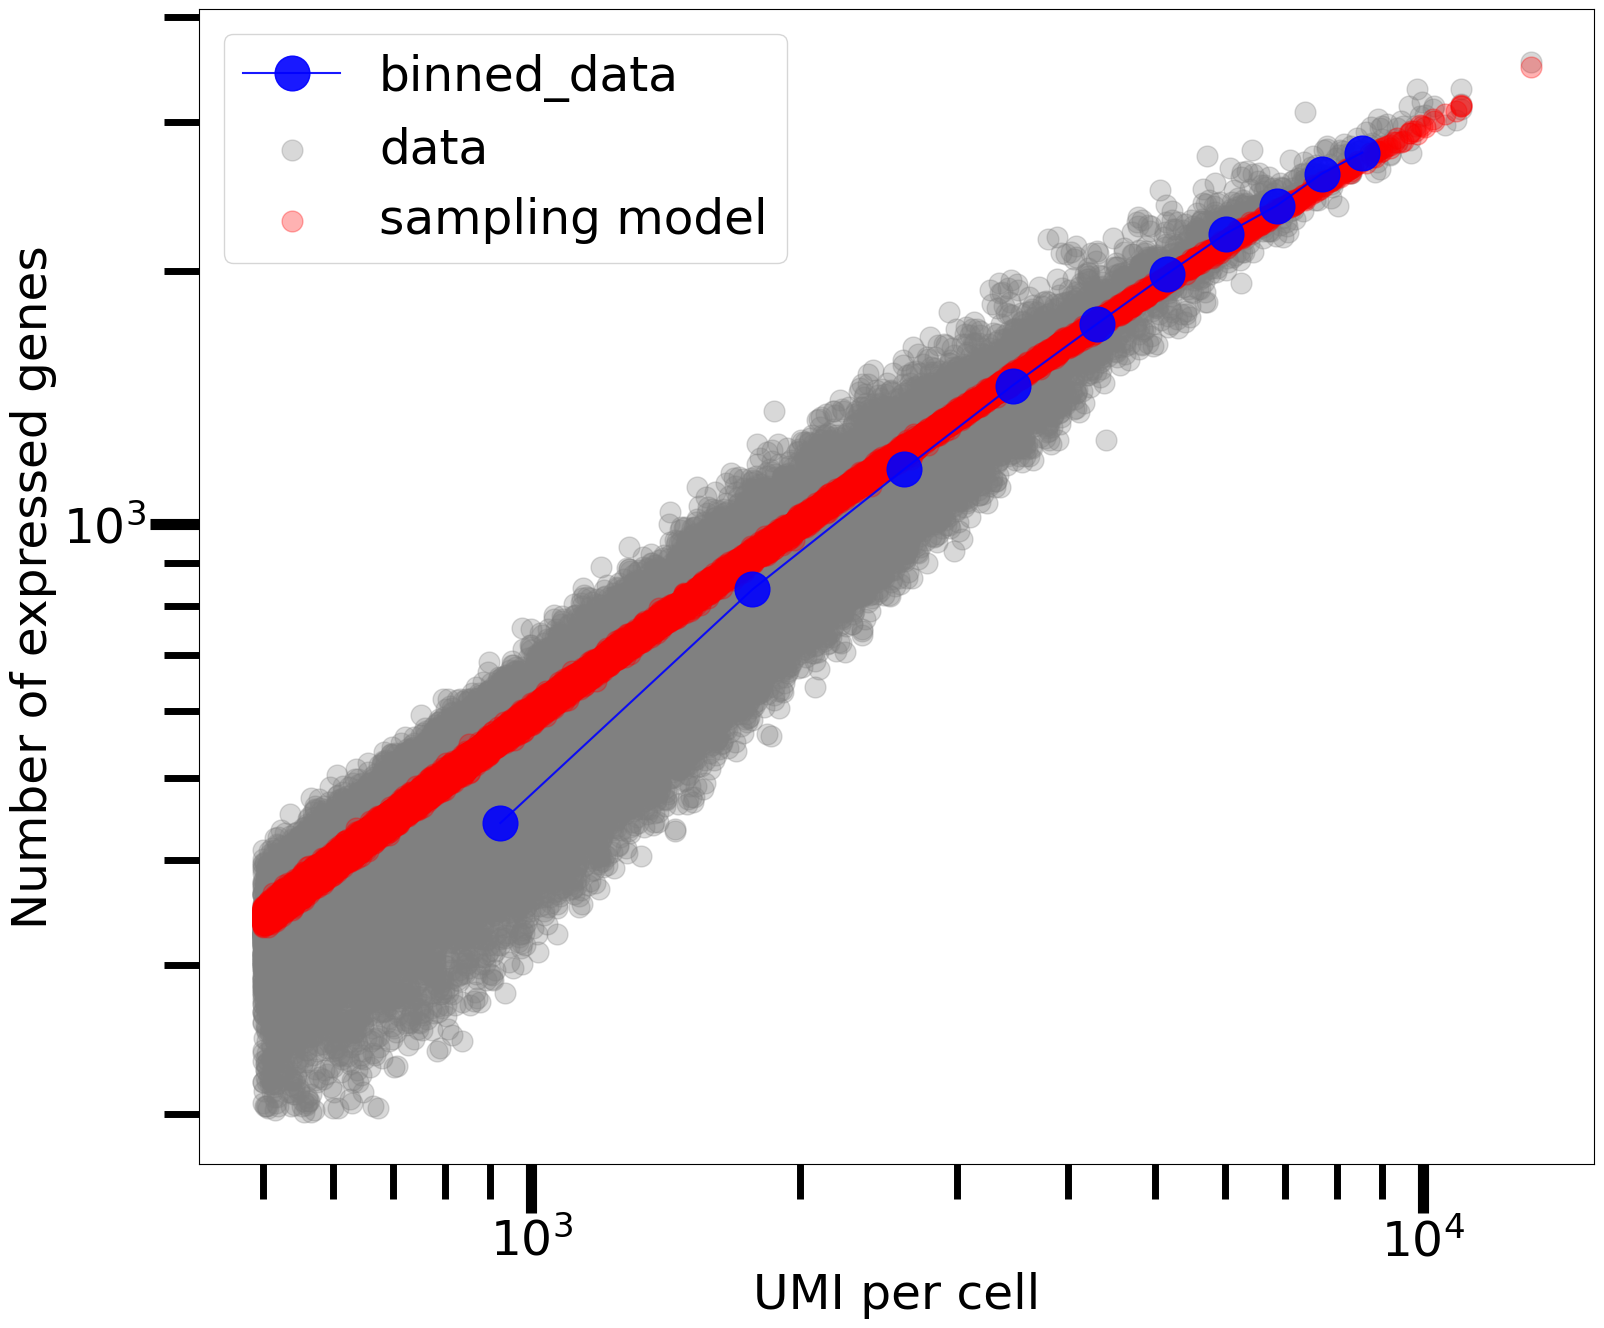

In [61]:
fig, ax = PyPlot.subplots(figsize=(18,15))

ax.scatter(data["data"]["M"], data["data"]["diffWords"], c="gray", alpha=0.3, s=225, label="data")
ax.scatter(data["mazzolini"]["M"], data["mazzolini"]["diffWords"], c="red", alpha=0.3, s=225, label="sampling model")

x_bins = (bin_edges[1:10] + bin_edges[2:11])/2
ax.plot(x_bins, bin_means[1:10], c="blue", alpha=0.9, ms=25, marker="o", label="binned_data")


ax.set_xlabel("UMI per cell", fontsize=35)
ax.set_ylabel("Number of expressed genes", fontsize=35)

ax.tick_params(labelsize=35, width=8, length=35)
ax.tick_params(which="minor", labelsize=35, width=5, length=25)


if loglog
    ax.set_xscale("log")
    ax.set_yscale("log")
end

ax.legend(fontsize=35)

PyPlot.show()
if loglog
    fig.savefig("heaps_boneMarrow_sampling_MCA_loglog.pdf")
else
    fig.savefig("heaps_boneMarrow_sampling_MCA.pdf")
end

### U

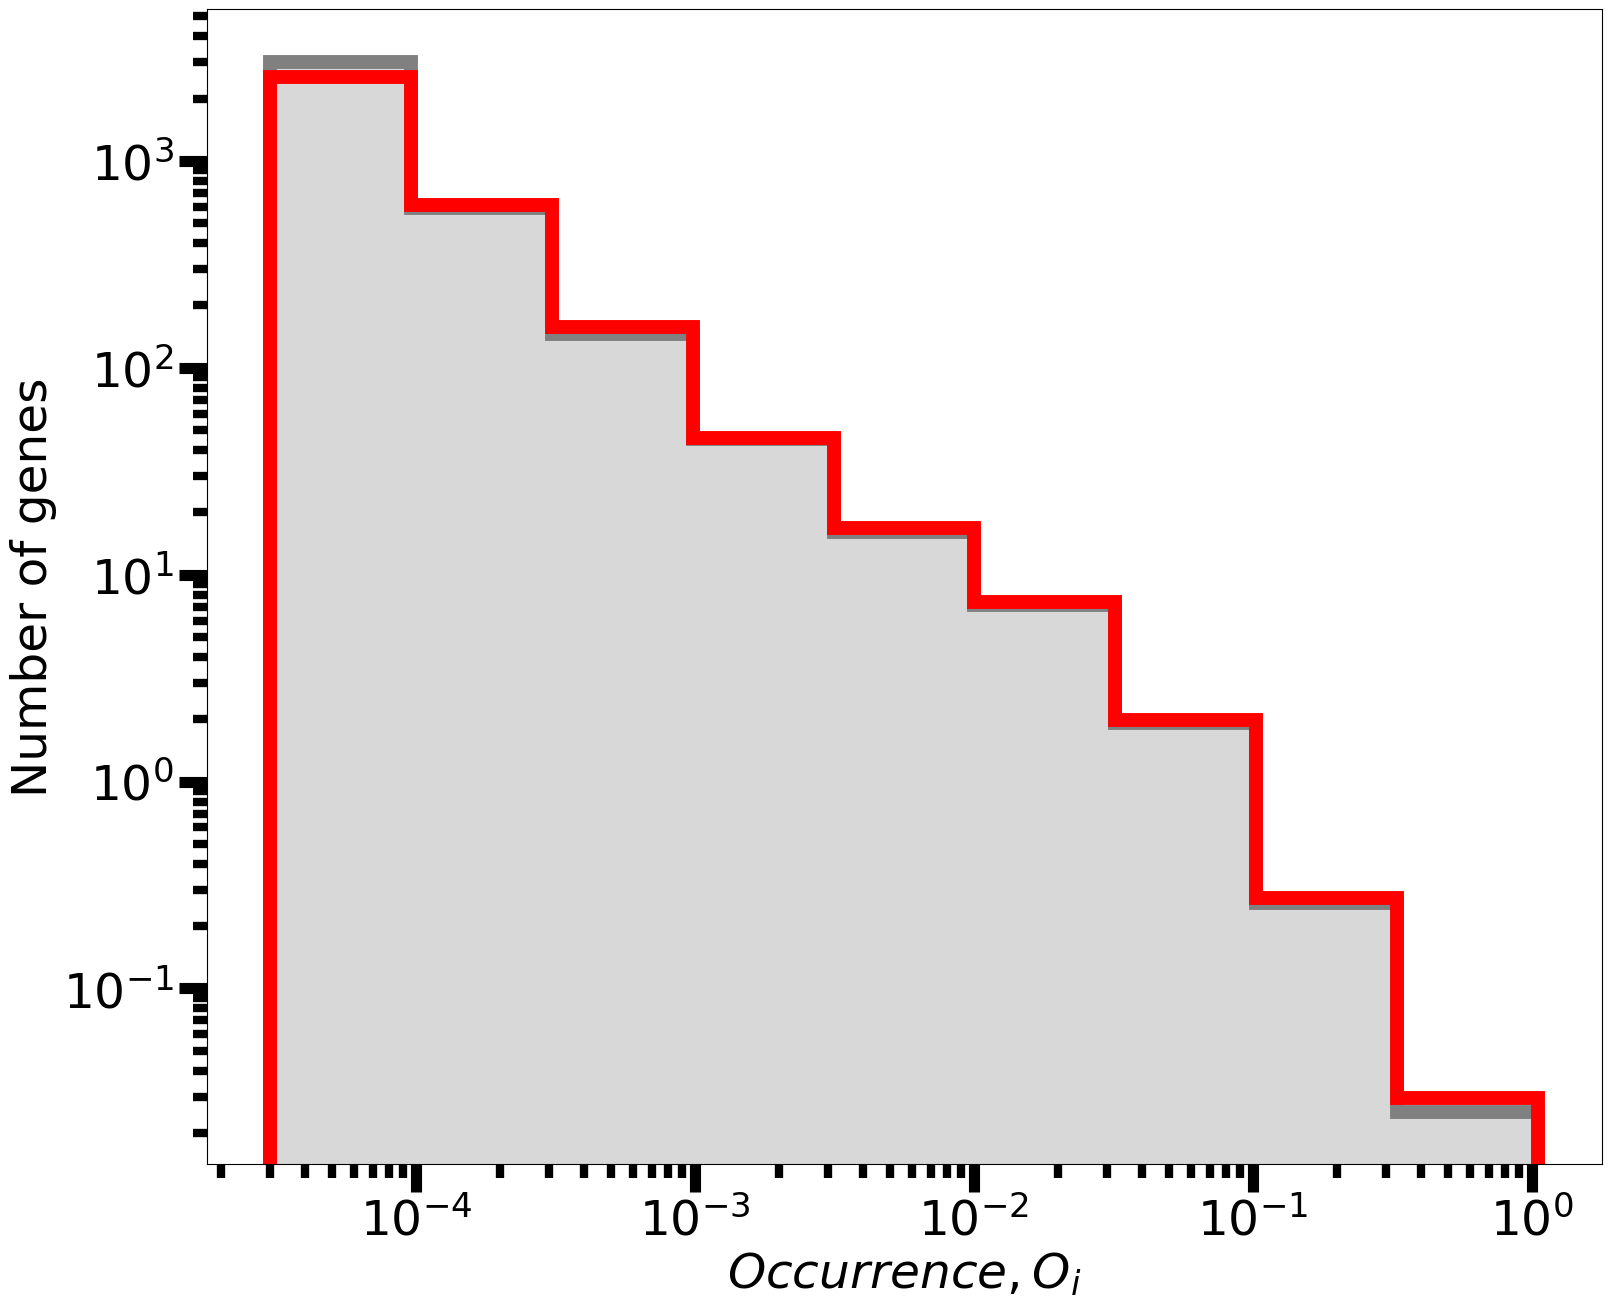

In [62]:
fig, ax = PyPlot.subplots(figsize=(18,15))

density=true

bins = [10^x for x in range(log10(3e-5), log10(1.05), length=10)]
#bins = 0.003:0.05:1.05
bin_counts, bin_edges = ax.hist(data["data"]["O"].values, color="gray", lw=10, histtype="step", bins=bins, density=density)

x_bins = (bin_edges[1:length(bin_edges)-1]+bin_edges[2:length(bin_edges)])/2
ax.hist(x_bins, weights=bin_counts, bins=bins, histtype="stepfilled", color="gray", lw=0, alpha=0.3)

bin_counts, bin_edges = ax.hist(data["mazzolini"]["O"], color="red", lw=10, histtype="step", bins=bins, density=density)


ax.set_xlabel(L"Occurrence, O_i", fontsize=35)
ax.set_ylabel("Number of genes", fontsize=35)

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(which="minor", width=6, length=10)

ax.set_yscale("log")
ax.set_xscale("log")

PyPlot.show()
fig.savefig("U_$(tissue)_mca.pdf")